# DSI-18 Project 2: Ames House Price Analysis

## Problem Statement

The Executive Committee of the Iowa Real Estate Investment Fund (IREIF) identified Ames as a high potential target to invest in. As part of the investment team in IREIF, we seek to understand why real estate in Ames is attracting attention as well as develop a model to predict the intrinsic value of houses in Ames so that the fund is able to make targeted investments and generate returns for our investors. 

## Executive Summary

Ames City is voted as the 9th best suburban city to live in and housing prices have shown a good resistence to the US Subprime Crisis. We explore approximately 2,500 housing transactions from the 2006-2010 period and identify features that were subsequently used in our regression models to assist in predicting the intrinsic value of the house. Our final model has good predictive accuracy up till the $300,000 valuation, thereafter, the predictions tend to under-predict actual house prices. Nonetheless, we believe the model is still useful in that it provides a margin of safety in predictions and will be a good tool to generate investment returns.

## Contents:

**Exploratory Data Analysis**
- [Getting to Know Ames](#Getting-to-Know-Ames)
- [Filling Up Missing Values](#Filling-Up-Missing-Values)
- [Brief Look At Our Target](#Brief-Look-At-Our-Target)
- [Exploring Categorical Features](#Exploring-Categorical-Features)
- [Exploring Quantitative Features](#Exploring-Quantitative-Features)
<br>

**Feature Selection & Model Testing**
- [Feature Selection and Validation](#Feature-Selection-and-Validation)
- [Optimal Model Selection and Testing](#Optimal-Model-Selection-and-Testing)
- [Conclusion](#Conclusion)
- [Addendum](#Addendum)

**Importing Tools**

In [1]:
import numpy as np 
import pandas as pd
pd.options.display.max_columns = 100 # number of columns to display
pd.options.display.max_rows = 200 # number of rows to display
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn') # set plt style

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

## Getting to Know Ames

Before we even deep dive into the dataset, we would like to get an overall understanding of Ames, the data, number of features, and what the features mean. Essentially, we would like to know the story that the data is telling us.<br>

As the number of features (columns) is huge, we will constantly make reference to the [data dictionary](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt) to get a grasp of what we are dealing with. <br>

But first, let us explore Ames:

### Ames City: A College Town & 9th Best Place to Live In

Ames is a city in the state of Iowa, according to [US Census](https://www.census.gov/) and information aggregated in [Wikipedia](https://en.wikipedia.org/wiki/Ames,_Iowa) and [Ames City](https://www.cityofames.org):

|Feature|Value|
|:--|--:|
|2019 Population| 66,258|
|Area| 71.69 Sq Km|
|Median Household Income| 46,127|
|Median Housing Value| 196,400|
|Total Housing Units| 26,754|
|Number of firms| 4,202|
|No. of students in Iowa State Uni|33,391|
|Top Employer|Iowa State Uni (16,811)| <br>

In terms of size and population, Ames is roughly one-tenth the size of Singapore, while its population is about one-hundredth Singapore's size. Hence, population density in Ames is low, with abundant land for huge houses. Conversely, apartments are rare. <br>

About 50% of the population in Ames are students from Iowa State University. The University itself is the top employer in the city, hiring 16,811. Including the employees and students, Iowa State University accounts for more than 75% of the population. Hence, Iowa is essentially a college town, with a younger population. Furthermore, there are estimated to be 26,754 housing units in Ames, translated to an average of 2.5 person per housing unit. <br>

Correspondingly, due to the high proportion of students, there are numerous shopping districts, restuarants, bars, cinemas, sports centers, stadium, golf courses and a municipal Airport. Ames is indeed a great suburban city to live in. In fact, when comparing small cities, Ames was voted as the 9th best places to live in according to [CNN](https://money.cnn.com/magazines/moneymag/bplive/2010/snapshots/PL1901855.html). <br>

Let's move on to look at our dataset:

In [2]:
ames = pd.read_csv('../datasets/train.csv')
ames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

In [3]:
ames['Yr Sold'].unique() #looking at which years our dataset range from

array([2010, 2009, 2006, 2007, 2008], dtype=int64)

We have 80 columns excluding our target - SalePrice with details on 2051 house transactions that occurred from 2006 to 2010. This translate to approximately 8% of the total number of houses in Ames.<br>

However, could there be houses that were transacted often during this period and was captured in our dataset? In other words, does our dataset of 2051 house transactions contains information for unique houses or are there houses that were repeated. If the latter is true, then we might run into a problem with the datapoints not being independent from each other. <br>

From our ames dataset, 'Id' might not be the best identifier for the houses as it might just be the numbering for house transactions. However, we do have 'PID' information, which conveys the Parcel ID of the houses. Each house in Ames should have a unique Parcel ID, so let's first change 'PID' to its correct datatype and use it to check for any repeated values:

In [4]:
ames['PID'] = ames['PID'].astype(str) # conversion of PID to string
ames['PID'].duplicated().any() # returns True if there are duplicates

False

As our search for any duplicated values in the PID column returns False, this means that there are no duplicated values in PID, implying all the houses in our dataset are unique.<br>

We also notice we have a feature called 'Neighborhood', indicating which neighborhood the houses are in. This could give us a broad sense of the location of the house. Furthermore, from the [research paper](http://jse.amstat.org/v19n3/decock.pdf) submitted by the author, the author mentioned that we could search the Parcel ID from [here](https://beacon.schneidercorp.com/) which contains many of the datapoints and others that might be helpful. One of the more helpful information was the address of the house, which helps us map the approximate location of the Neighborhood in Ames. 

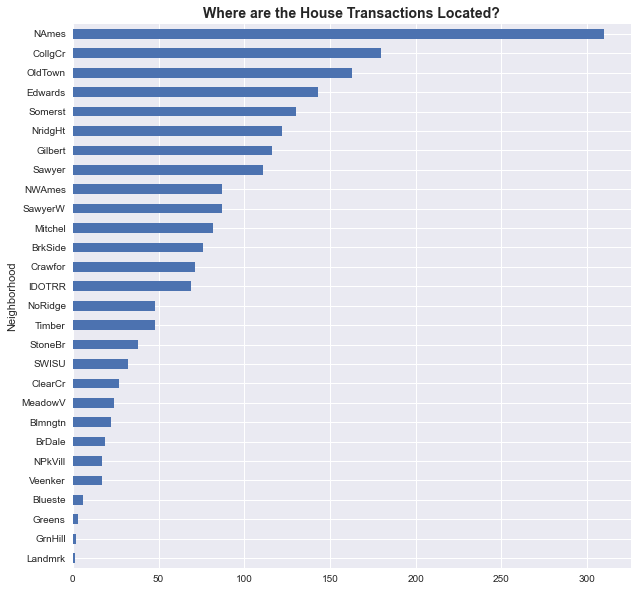

In [5]:
ames.groupby('Neighborhood').Id.count().sort_values().plot(kind='barh', figsize=(10,10))
plt.title('Where are the House Transactions Located?', fontweight='bold', fontsize=14)
plt.show()

We see that the House Transactions are not uniformly spread across the neighborhoods, which could also be an indication of the size of the neighborhood. Let us see where the Neighborhood might be located in Ames:

**Location of Ames Neighborhoods** 

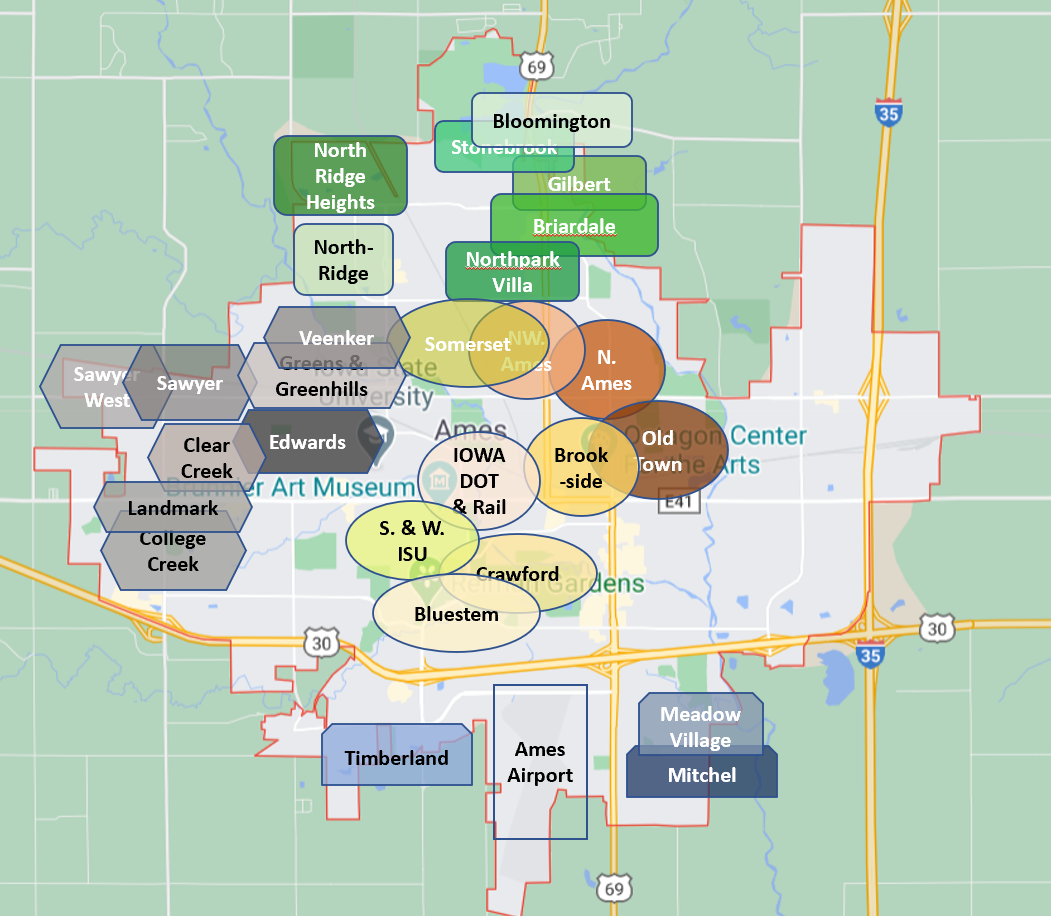

In [6]:
# finding the average Year Built of houses in each Neighborhood
ames.groupby(by='Neighborhood')['Year Built'].mean().sort_values()

Neighborhood
OldTown    1922.950920
IDOTRR     1928.043478
SWISU      1931.312500
BrkSide    1933.144737
Crawfor    1947.704225
Edwards    1956.363636
NAmes      1960.103226
Sawyer     1962.936937
ClearCr    1968.592593
BrDale     1971.789474
MeadowV    1972.500000
NPkVill    1976.235294
NWAmes     1976.298851
Greens     1978.666667
Mitchel    1982.097561
Blueste    1983.000000
Veenker    1983.411765
SawyerW    1991.310345
GrnHill    1992.000000
Landmrk    1993.000000
NoRidge    1995.479167
Timber     1996.166667
Gilbert    1997.922414
CollgCr    1998.422222
StoneBr    1998.842105
Somerst    2004.753846
Blmngtn    2005.090909
NridgHt    2005.393443
Name: Year Built, dtype: float64

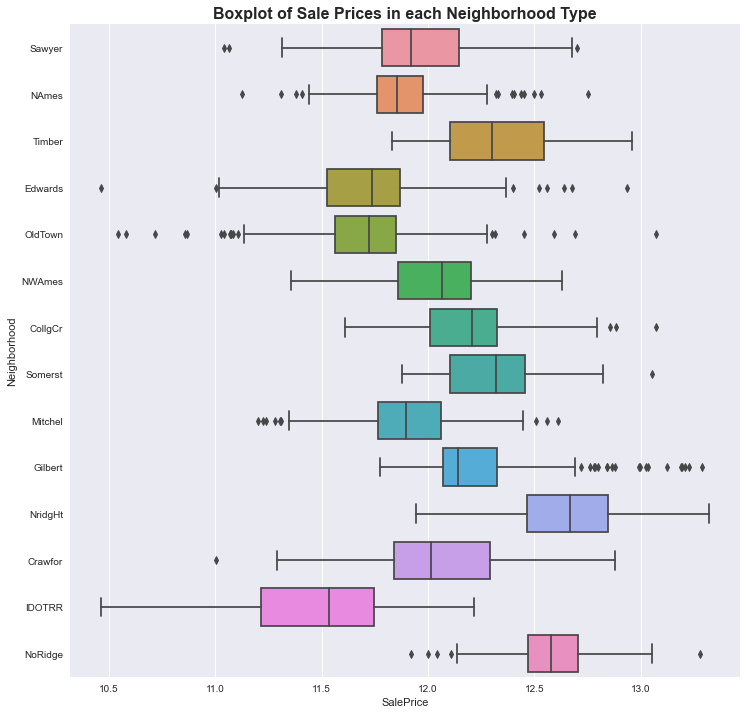

In [264]:
plt.figure(figsize=(12,12))
ax = sns.boxplot(y='Neighborhood', x='SalePrice', data=ames)
ax.set_title('Boxplot of Sale Prices in each Neighborhood Type', fontsize='16', fontweight='bold');

With the previously mentioned tools, we came up with a general sense of the locations of each districts within Ames itself. Also, just this information provides us with a background of Ames: We see that Ames housing districts are spread into 4 locations, the central area which is probably the first to developed with names like Old Town and Iowa Department of Transport & Rail. This probably coincide with where the main activity in Ames was in the past.<br>

Next, as Ames developed and flourish, they expanded into the West, beyond Iowa State University and South areas, which is near Ames Municipal Airport, before finally expanding further north. <br> 

As there are 28 different districts in our Neighborhood column and some of these Neighborhoods are rather small, we might possibly want to combine some of these districts based on logical considerations like their location on the map using the tools we have:

Firstly, let's look at the smaller frequency Neighborhoods. Intuitively, we think that they are part of a larger neighborhood and thus, their SalePrice would be largely similar:
    - Landmark into College Creek
    - Greens, Greenhills, Veenker into NoRidge
    - Bluestem, SWISU into Crawford
    - Brdale, NPkVill into NWames
    - Blmngtn, StoneBr into Gilbert
    - MeadowV into Mitchel
    - ClearCr, SawyerW into Sawyer
    - BrkSide into OldTown

In [8]:
# create dict of neighborhoods to replace based on above
neighbor_replace = {'Landmrk': 'CollgCr', 'Greens': 'NoRidge', 'GrnHill': 'NoRidge',
                   'Veenker': 'NoRidge', 'Blueste': 'Crawfor', 'SWISU': 'Crawfor',
                   'BrDale': 'NWAmes', 'NPkVill': 'NWAmes', 'Blmngtn': 'Gilbert', 
                   'StoneBr': 'Gilbert', 'MeadowV': 'Mitchel', 'ClearCr': 'Sawyer', 
                   'SawyerW': 'Sawyer', 'BrkSide': 'OldTown'}

ames['Neighborhood'].replace(neighbor_replace, inplace=True)

In [9]:
ames['Neighborhood'].value_counts()

NAmes      310
OldTown    239
Sawyer     225
CollgCr    181
Gilbert    176
Edwards    143
Somerst    130
NWAmes     123
NridgHt    122
Crawfor    109
Mitchel    106
NoRidge     70
IDOTRR      69
Timber      48
Name: Neighborhood, dtype: int64

Incorporating these changes, we are left with 14 neighborhoods. We also incorporate some of the amenities in Ames into our map to let us know Ames better:

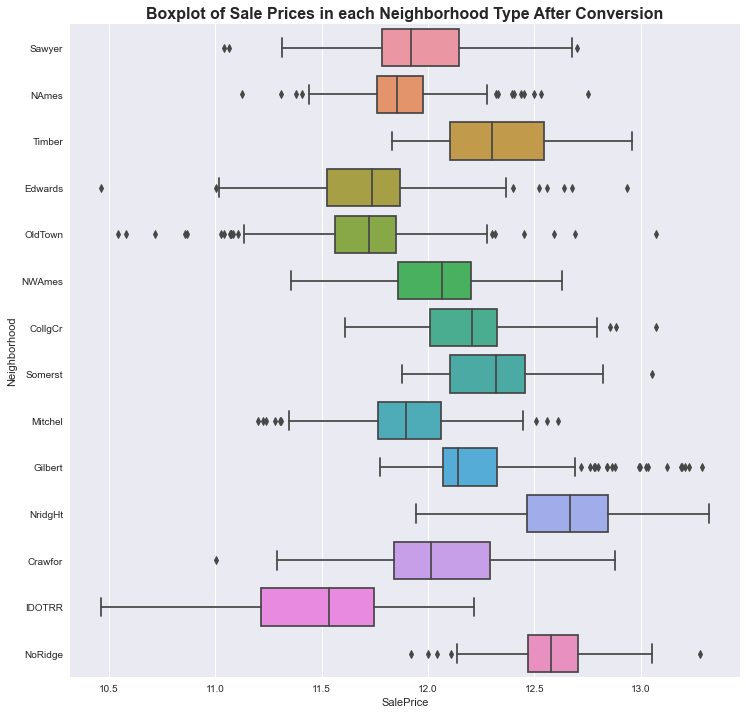

In [265]:
plt.figure(figsize=(12,12))
ax = sns.boxplot(y='Neighborhood', x='SalePrice', data=ames)
ax.set_title('Boxplot of Sale Prices in each Neighborhood Type After Conversion', fontsize='16', fontweight='bold');

**Location of Ames Neighborhoods After Grouping** 

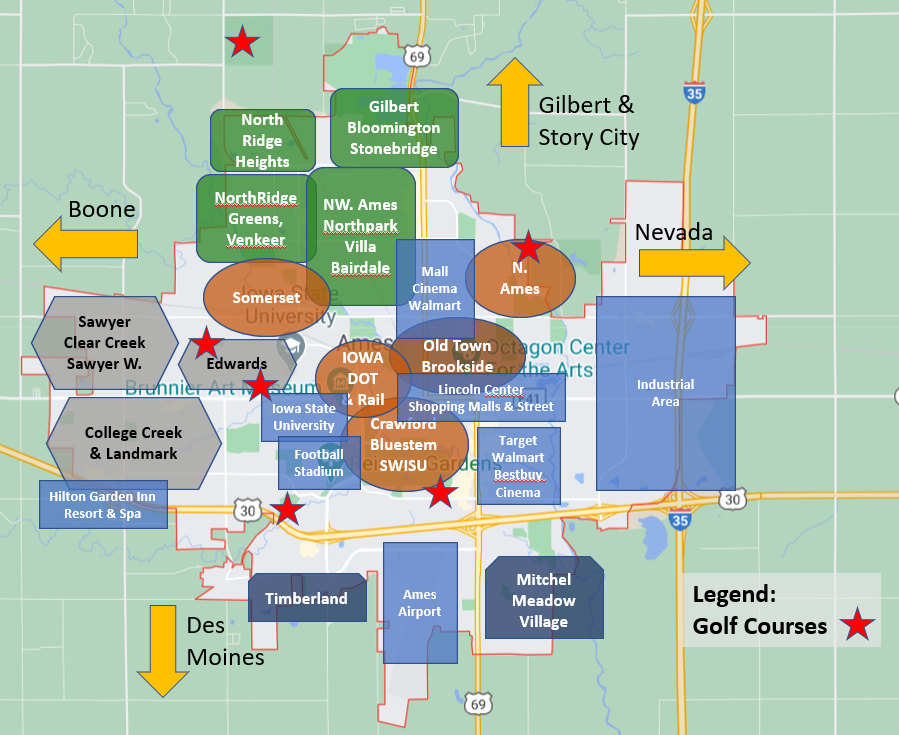

Does it make sense to group the neighborhoods like this? We have made a judgement call, essentially, we feel that houses/apartments that are in similar location should be judged on the same basis in terms of its location. Any differences in price within the same location would be due to the overall age, size, quality, condition and other individual features of these houses/apartments. 

## Filling Up Missing Values

Next, let's proceed to check for missing values and fill them up before we look at each feature in detail:

In [11]:
ames.isnull().sum() # checking for missing values

Id                    0
PID                   0
MS SubClass           0
MS Zoning             0
Lot Frontage        330
Lot Area              0
Street                0
Alley              1911
Lot Shape             0
Land Contour          0
Utilities             0
Lot Config            0
Land Slope            0
Neighborhood          0
Condition 1           0
Condition 2           0
Bldg Type             0
House Style           0
Overall Qual          0
Overall Cond          0
Year Built            0
Year Remod/Add        0
Roof Style            0
Roof Matl             0
Exterior 1st          0
Exterior 2nd          0
Mas Vnr Type         22
Mas Vnr Area         22
Exter Qual            0
Exter Cond            0
Foundation            0
Bsmt Qual            55
Bsmt Cond            55
Bsmt Exposure        58
BsmtFin Type 1       55
BsmtFin SF 1          1
BsmtFin Type 2       56
BsmtFin SF 2          1
Bsmt Unf SF           1
Total Bsmt SF         1
Heating               0
Heating QC      

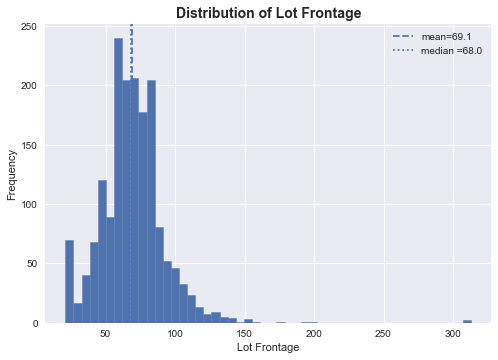

In [12]:
column = 'Lot Frontage'
plt.hist(ames[column], edgecolor='slategray', linewidth=0.5, bins=50)
plt.axvline(ames[column].mean(), label=f'mean={round(ames[column].mean(),1)}', ls='--')
plt.axvline(ames[column].median(), label=f'median ={round(ames[column].median(),1)}', ls=':')
plt.title(f'Distribution of {column}', fontsize=14, fontweight='bold')
plt.legend()
plt.xlabel(column)
plt.ylabel('Frequency')
plt.show()

We observed a right skew in the distribution with a few significant positive outliers. However, the mean and median of the distribution did not differ by much perhaps due to the large clustering of values around the median (50th percentile). Thus, without further insights, especially from the data documentation, we shall set it to be equal to the median:

In [13]:
# identify the null cells and fill it with the median value for Lot Frontage
ames['Lot Frontage'].fillna(ames['Lot Frontage'].median(), inplace=True)

Next, we investigate the other null values. We would like to check to see if these null values are for the same rows for values that are related:

In [14]:
len(ames.loc[(ames['Bsmt Qual'].isnull()) | 
             (ames['Bsmt Cond'].isnull()) |
             (ames['BsmtFin Type 1'].isnull())
             ])

55

In [15]:
len(ames.loc[(ames['Garage Yr Blt'].isnull()) | 
             (ames['Garage Finish'].isnull()) |
             (ames['Garage Qual'].isnull()) |
             (ames['Garage Cond'].isnull())
             ])

114

In [16]:
len(ames.loc[(ames['Mas Vnr Type'].isnull()) | (ames['Mas Vnr Area'].isnull())])

22

All nulls in the 3 groups above are from the same rows. Hence we can deal with them as a group later on. Additionally, we did not include Bsmt Exposure, BsmtFin Type 2, Garage  Type in the grouping is because their null values didn't match. This implies that there are potentially rows that do not match the rest and we would like to investigate these in further detail.<br>

Let us fill the missing values for the features that we are confident in:

In [17]:
# listing out the columns where missing values are houses without such features 
na_features = ['Alley', 'Mas Vnr Type', 'Bsmt Qual', 
               'Bsmt Cond', 'BsmtFin Type 1', 'Fireplace Qu', 
               'Garage Type', 'Pool QC', 'Fence', 
               'Misc Feature']
# loop through each feature and insert NA for missing values
for feature in na_features:
    ames[feature].fillna('NA', inplace=True )

In [18]:
ames['Mas Vnr Area'].fillna(0, inplace=True )

For Bsmt Exposure, let's look at those null values that correspond to NA values in Bsmt Cond (previously 55 null values) and identify the 3 values that do not match:

In [19]:
ames.loc[(ames['Bsmt Exposure'].isnull()) != (ames['Bsmt Cond'] == 'NA')]

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
1456  1797  528458090           60        FV          81.0     10411   Pave   
1547    67  528445060           20        RL          73.0      8987   Pave   
1997  2780  907194130           60        RL          65.0     14006   Pave   

     Alley Lot Shape Land Contour Utilities Lot Config Land Slope  \
1456    NA       Reg          Lvl    AllPub     Corner        Gtl   
1547    NA       Reg          Lvl    AllPub     Inside        Gtl   
1997    NA       IR1          Lvl    AllPub     Inside        Gtl   

     Neighborhood Condition 1 Condition 2 Bldg Type House Style  Overall Qual  \
1456      Somerst        Norm        Norm      1Fam      2Story             5   
1547      Somerst        Norm        Norm      1Fam      1Story             8   
1997      CollgCr        Norm        Norm      1Fam      2Story             7   

      Overall Cond  Year Built  Year Remod/Add Roof Style Roof Matl  \
1456             5        2007            2007      Gable   CompShg   
1547             5        2005            2006      Gable   CompShg   
1997             5        2002            2002      Gable   CompShg   

     Exterior 1st Exterior 2nd Mas Vnr Type  Mas Vnr Area Exter Qual  \
1456      VinylSd      VinylSd         None           0.0         Gd   
1547      VinylSd      VinylSd      BrkFace         226.0         Gd   
1997      VinylSd      VinylSd      BrkFace         144.0         Gd   

     Exter Cond Foundation Bsmt Qual Bsmt Cond Bsmt Exposure BsmtFin Type 1  \
1456         TA     CBlock        Gd        TA           NaN            Unf   
1547         TA      PConc        Gd        TA           NaN            Unf   
1997         TA      PConc        Gd        TA           NaN            Unf   

      BsmtFin SF 1 BsmtFin Type 2  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  \
1456           0.0            Unf           0.0        725.0          725.0   
1547           0.0            Unf           0.0       1595.0         1595.0   
1997           0.0            Unf           0.0        936.0          936.0   

     Heating Heating QC Central Air Electrical  1st Flr SF  2nd Flr SF  \
1456    GasA         Ex           Y      SBrkr         725         863   
1547    GasA         Ex           Y      SBrkr        1595           0   
1997    GasA         Ex           Y      SBrkr         936         840   

      Low Qual Fin SF  Gr Liv Area  Bsmt Full Bath  Bsmt Half Bath  Full Bath  \
1456                0         1588             0.0             0.0          3   
1547                0         1595             0.0             0.0          2   
1997                0         1776             0.0             0.0          2   

      Half Bath  Bedroom AbvGr  Kitchen AbvGr Kitchen Qual  TotRms AbvGrd  \
1456          0              3              1           Gd              8   
1547          0              2              1           Gd              6   
1997          1              3              1           Gd              7   

     Functional  Fireplaces Fireplace Qu Garage Type  Garage Yr Blt  \
1456        Typ           0           NA      Attchd         2007.0   
1547        Typ           1           Gd      Attchd         2005.0   
1997        Typ           1           TA      Attchd         2002.0   

     Garage Finish  Garage Cars  Garage Area Garage Qual Garage Cond  \
1456           Unf          2.0        561.0          TA          TA   
1547           RFn          3.0        880.0          TA          TA   
1997           RFn          2.0        474.0          TA          TA   

     Paved Drive  Wood Deck SF  Open Porch SF  Enclosed Porch  3Ssn Porch  \
1456           Y             0              0               0           0   
1547           Y           144              0               0           0   
1997           Y           144             96               0           0   

      Screen Porch  Pool Area Pool QC Fence Misc Feature  Misc Val 

Refering to the data documentation, it would seem that these houses have basements, but they do not have basement exposure. Hence, let's input 'No' for these 3 houses, and 'NA' for the remaining 55:

In [20]:
ames['Bsmt Exposure'].value_counts() #checking unique values of Bsmt Exposure

No    1339
Av     288
Gd     203
Mn     163
Name: Bsmt Exposure, dtype: int64

In [21]:
# accessing the rows through their index using .loc and set to 'No'
ames.loc[[1456, 1547, 1997], 'Bsmt Exposure'] = 'No'

In [22]:
ames['Bsmt Exposure'].fillna('NA', inplace=True )

In [23]:
# similarly, we try to identify the house for BsmtFin Type 2
ames.loc[(ames['BsmtFin Type 2'].isnull()) != (ames['Bsmt Cond'] == 'NA')]

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
1147  445  528142130           20        RL          85.0     10655   Pave   

     Alley Lot Shape Land Contour Utilities Lot Config Land Slope  \
1147    NA       IR1          Lvl    AllPub     Inside        Gtl   

     Neighborhood Condition 1 Condition 2 Bldg Type House Style  Overall Qual  \
1147      NridgHt        Norm        Norm      1Fam      1Story             8   

      Overall Cond  Year Built  Year Remod/Add Roof Style Roof Matl  \
1147             5        2003            2004      Gable   CompShg   

     Exterior 1st Exterior 2nd Mas Vnr Type  Mas Vnr Area Exter Qual  \
1147      VinylSd      VinylSd      BrkFace         296.0         Gd   

     Exter Cond Foundation Bsmt Qual Bsmt Cond Bsmt Exposure BsmtFin Type 1  \
1147         TA      PConc        Gd        TA            No            GLQ   

      BsmtFin SF 1 BsmtFin Type 2  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  \
1147        1124.0            NaN         479.0       1603.0         3206.0   

     Heating Heating QC Central Air Electrical  1st Flr SF  2nd Flr SF  \
1147    GasA         Ex           Y      SBrkr        1629           0   

      Low Qual Fin SF  Gr Liv Area  Bsmt Full Bath  Bsmt Half Bath  Full Bath  \
1147                0         1629             1.0             0.0          2   

      Half Bath  Bedroom AbvGr  Kitchen AbvGr Kitchen Qual  TotRms AbvGrd  \
1147          0              3              1           Gd              7   

     Functional  Fireplaces Fireplace Qu Garage Type  Garage Yr Blt  \
1147        Typ           1           Gd      Attchd         2003.0   

     Garage Finish  Garage Cars  Garage Area Garage Qual Garage Cond  \
1147           RFn          3.0        880.0          TA          TA   

     Paved Drive  Wood Deck SF  Open Porch SF  Enclosed Porch  3Ssn Porch  \
1147           Y             0              0               0           0   

      Screen Porch  Pool Area Pool QC Fence Misc Feature  Misc Val  Mo Sold  \
1147             0          0      NA    NA           NA         0       10   

      Yr Sold Sale Type  SalePrice  
1147     2009       WD      284000

It seems this house has a large basement with 2 different types. BsmtFin Type 1 is considered a 'Good Living Quaters' while the value for BsmtFin Type 2 is missing even though the square feet is listed with a non-null value. The Data Documentation specifies:<br>
          
    BsmtFinType 2(Ordinal): Rating of basement finished area (if multiple types) 
    
Hence, the value here must be different from 'GLQ'(Good Living Quaters). Taking into account that the Bsmt Qual is good, we feel 'ALQ' (Average Living Quarters) is a good fit for this missing value and we set the rest to 'NA':

In [24]:
ames['BsmtFin Type 2'].value_counts()

Unf    1749
Rec      80
LwQ      60
BLQ      48
ALQ      35
GLQ      23
Name: BsmtFin Type 2, dtype: int64

In [25]:
ames.loc[1147, 'BsmtFin Type 2'] = 'ALQ'

In [26]:
ames['BsmtFin Type 2'].fillna('NA', inplace=True )

In [27]:
ames.loc[ames['BsmtFin SF 1'].isnull()]

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
1327  1342  903230120           20        RM          99.0      5940   Pave   

     Alley Lot Shape Land Contour Utilities Lot Config Land Slope  \
1327    NA       IR1          Lvl    AllPub        FR3        Gtl   

     Neighborhood Condition 1 Condition 2 Bldg Type House Style  Overall Qual  \
1327      OldTown       Feedr        Norm      1Fam      1Story             4   

      Overall Cond  Year Built  Year Remod/Add Roof Style Roof Matl  \
1327             7        1946            1950      Gable   CompShg   

     Exterior 1st Exterior 2nd Mas Vnr Type  Mas Vnr Area Exter Qual  \
1327      MetalSd       CBlock         None           0.0         TA   

     Exter Cond Foundation Bsmt Qual Bsmt Cond Bsmt Exposure BsmtFin Type 1  \
1327         TA      PConc        NA        NA            NA             NA   

      BsmtFin SF 1 BsmtFin Type 2  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  \
1327           NaN             NA           NaN          NaN            NaN   

     Heating Heating QC Central Air Electrical  1st Flr SF  2nd Flr SF  \
1327    GasA         TA           Y      FuseA         896           0   

      Low Qual Fin SF  Gr Liv Area  Bsmt Full Bath  Bsmt Half Bath  Full Bath  \
1327                0          896             NaN             NaN          1   

      Half Bath  Bedroom AbvGr  Kitchen AbvGr Kitchen Qual  TotRms AbvGrd  \
1327          0              2              1           TA              4   

     Functional  Fireplaces Fireplace Qu Garage Type  Garage Yr Blt  \
1327        Typ           0           NA      Detchd         1946.0   

     Garage Finish  Garage Cars  Garage Area Garage Qual Garage Cond  \
1327           Unf          1.0        280.0          TA          TA   

     Paved Drive  Wood Deck SF  Open Porch SF  Enclosed Porch  3Ssn Porch  \
1327           Y             0              0               0           0   

      Screen Porch  Pool Area Pool QC  Fence Misc Feature  Misc Val  Mo Sold  \
1327             0          0      NA  MnPrv           NA         0        4   

      Yr Sold Sale Type  SalePrice  
1327     2008     ConLD      79000

This is straightfoward - the missing entries for Basement SF features will be 0 since this house does not have a basement.

In [28]:
# similarly, access the index of this house, and input 0 for the missing values
ames.loc[1327, ['BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF']] = 0

In [29]:
ames.loc[ames['Bsmt Full Bath'].isnull()]

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
616   1498  908154080           20        RL         123.0     47007   Pave   
1327  1342  903230120           20        RM          99.0      5940   Pave   

     Alley Lot Shape Land Contour Utilities Lot Config Land Slope  \
616     NA       IR1          Lvl    AllPub     Inside        Gtl   
1327    NA       IR1          Lvl    AllPub        FR3        Gtl   

     Neighborhood Condition 1 Condition 2 Bldg Type House Style  Overall Qual  \
616       Edwards        Norm        Norm      1Fam      1Story             5   
1327      OldTown       Feedr        Norm      1Fam      1Story             4   

      Overall Cond  Year Built  Year Remod/Add Roof Style Roof Matl  \
616              7        1959            1996      Gable   CompShg   
1327             7        1946            1950      Gable   CompShg   

     Exterior 1st Exterior 2nd Mas Vnr Type  Mas Vnr Area Exter Qual  \
616       Plywood      Plywood         None           0.0         TA   
1327      MetalSd       CBlock         None           0.0         TA   

     Exter Cond Foundation Bsmt Qual Bsmt Cond Bsmt Exposure BsmtFin Type 1  \
616          TA       Slab        NA        NA            NA             NA   
1327         TA      PConc        NA        NA            NA             NA   

      BsmtFin SF 1 BsmtFin Type 2  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  \
616            0.0             NA           0.0          0.0            0.0   
1327           0.0             NA           0.0          0.0            0.0   

     Heating Heating QC Central Air Electrical  1st Flr SF  2nd Flr SF  \
616     GasA         TA           Y      SBrkr        3820           0   
1327    GasA         TA           Y      FuseA         896           0   

      Low Qual Fin SF  Gr Liv Area  Bsmt Full Bath  Bsmt Half Bath  Full Bath  \
616                 0         3820             NaN             NaN          3   
1327                0          896             NaN             NaN          1   

      Half Bath  Bedroom AbvGr  Kitchen AbvGr Kitchen Qual  TotRms AbvGrd  \
616           1              5              1           Ex             11   
1327          0              2              1           TA              4   

     Functional  Fireplaces Fireplace Qu Garage Type  Garage Yr Blt  \
616         Typ           2           Gd      Attchd         1959.0   
1327        Typ           0           NA      Detchd         1946.0   

     Garage Finish  Garage Cars  Garage Area Garage Qual Garage Cond  \
616            Unf          2.0        624.0          TA          TA   
1327           Unf          1.0        280.0          TA          TA   

     Paved Drive  Wood Deck SF  Open Porch SF  Enclosed Porch  3Ssn Porch  \
616            Y             0            372               0           0   
1327           Y             0              0               0           0   

      Screen Porch  Pool Area Pool QC  Fence Misc Feature  Misc Val  Mo Sold  \
616              0          0      NA     NA           NA         0        7   
1327             0          0      NA  MnPrv           NA         0        4   

      Yr Sold Sale Type  SalePrice  
616      2008       WD      284700  
1327     2008     ConLD      79000

Likewise, as they do not have a basement, we input 0 as their value for Bsmt Full Bath and Bsmt Half Bath:

In [30]:
ames.loc[[616, 1327], ['Bsmt Full Bath', 'Bsmt Half Bath']] = 0

In [31]:
# identifying the house for Garage Finish
ames.loc[(ames['Garage Finish'].isnull()) != (ames['Garage Type'] == 'NA')]

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
1712  2237  910201180           70        RM          50.0      9060   Pave   

     Alley Lot Shape Land Contour Utilities Lot Config Land Slope  \
1712    NA       Reg          Lvl    AllPub     Inside        Gtl   

     Neighborhood Condition 1 Condition 2 Bldg Type House Style  Overall Qual  \
1712       IDOTRR        Norm        Norm      1Fam      2Story             5   

      Overall Cond  Year Built  Year Remod/Add Roof Style Roof Matl  \
1712             6        1923            1999      Gable   CompShg   

     Exterior 1st Exterior 2nd Mas Vnr Type  Mas Vnr Area Exter Qual  \
1712      Wd Sdng      Plywood         None           0.0         TA   

     Exter Cond Foundation Bsmt Qual Bsmt Cond Bsmt Exposure BsmtFin Type 1  \
1712         TA     BrkTil        Gd        TA            No            ALQ   

      BsmtFin SF 1 BsmtFin Type 2  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  \
1712         548.0            Unf           0.0        311.0          859.0   

     Heating Heating QC Central Air Electrical  1st Flr SF  2nd Flr SF  \
1712    GasA         Ex           Y      SBrkr         942         886   

      Low Qual Fin SF  Gr Liv Area  Bsmt Full Bath  Bsmt Half Bath  Full Bath  \
1712                0         1828             0.0             0.0          2   

      Half Bath  Bedroom AbvGr  Kitchen AbvGr Kitchen Qual  TotRms AbvGrd  \
1712          0              3              1           Gd              6   

     Functional  Fireplaces Fireplace Qu Garage Type  Garage Yr Blt  \
1712        Typ           0           NA      Detchd            NaN   

     Garage Finish  Garage Cars  Garage Area Garage Qual Garage Cond  \
1712           NaN          NaN          NaN         NaN         NaN   

     Paved Drive  Wood Deck SF  Open Porch SF  Enclosed Porch  3Ssn Porch  \
1712           Y           174              0             212           0   

      Screen Porch  Pool Area Pool QC  Fence Misc Feature  Misc Val  Mo Sold  \
1712             0          0      NA  MnPrv           NA         0        3   

      Yr Sold Sale Type  SalePrice  
1712     2007       WD      150909

We are faced with a dilemma for this house - the 'Garage Type' is listed as Detchd, pointing to an existence of a garage, but the other details for garage are missing. We could:<br>
1. Treat the 'Garage Type' value as a mistake, and that the house truly does not have a garage. Or, <br>
2. Fill the rest of the garage indicators with references to the mean or median<br>

We initially chose option 2, but when we were trying to find out the location of the neighborhoods, and looking at the Data Documentation, we realized that we could do a search for the house details using its Parcel ID. Using the Parcel ID to search for the house, we arrive at the conclusion that this house does not have a garage.<br> 

[Source](https://qpublic.schneidercorp.com/Application.aspx?AppID=165&LayerID=2145&PageTypeID=4&PageID=1108&Q=986856941&KeyValue=0910201180)

In [32]:
# setting features to be NA
ames.loc[1712, ['Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond']] = 'NA'

# setting other features to be 0
ames.loc[1712, ['Garage Yr Blt', 'Garage Cars', 'Garage Area']] = 0

Since there should be no more mis-matches, we can fill out the remaining missing values broadly.<br>

For Garage Yr Blt, we acknowledge that filling 0 might not make sense, however, we also do not want to remove these rows that do not have a garage. We arrive at a compromise, and make a mental note of this when we look at the scatter plot for Garage Yr Blt:

In [33]:
ames['Garage Finish'].fillna('NA', inplace=True)
ames['Garage Qual'].fillna('NA', inplace=True)
ames['Garage Cond'].fillna('NA', inplace=True)

ames['Garage Yr Blt'].fillna(0, inplace=True)

In [34]:
ames.isnull().sum() # final check for missing values

Id                 0
PID                0
MS SubClass        0
MS Zoning          0
Lot Frontage       0
Lot Area           0
Street             0
Alley              0
Lot Shape          0
Land Contour       0
Utilities          0
Lot Config         0
Land Slope         0
Neighborhood       0
Condition 1        0
Condition 2        0
Bldg Type          0
House Style        0
Overall Qual       0
Overall Cond       0
Year Built         0
Year Remod/Add     0
Roof Style         0
Roof Matl          0
Exterior 1st       0
Exterior 2nd       0
Mas Vnr Type       0
Mas Vnr Area       0
Exter Qual         0
Exter Cond         0
Foundation         0
Bsmt Qual          0
Bsmt Cond          0
Bsmt Exposure      0
BsmtFin Type 1     0
BsmtFin SF 1       0
BsmtFin Type 2     0
BsmtFin SF 2       0
Bsmt Unf SF        0
Total Bsmt SF      0
Heating            0
Heating QC         0
Central Air        0
Electrical         0
1st Flr SF         0
2nd Flr SF         0
Low Qual Fin SF    0
Gr Liv Area  

## Brief Look At Our Target

Let's check out sale price, our target variable and see if we can glean any initial insights from it:

In [35]:
ames['SalePrice'].describe()

count      2051.000000
mean     181469.701609
std       79258.659352
min       12789.000000
25%      129825.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: SalePrice, dtype: float64

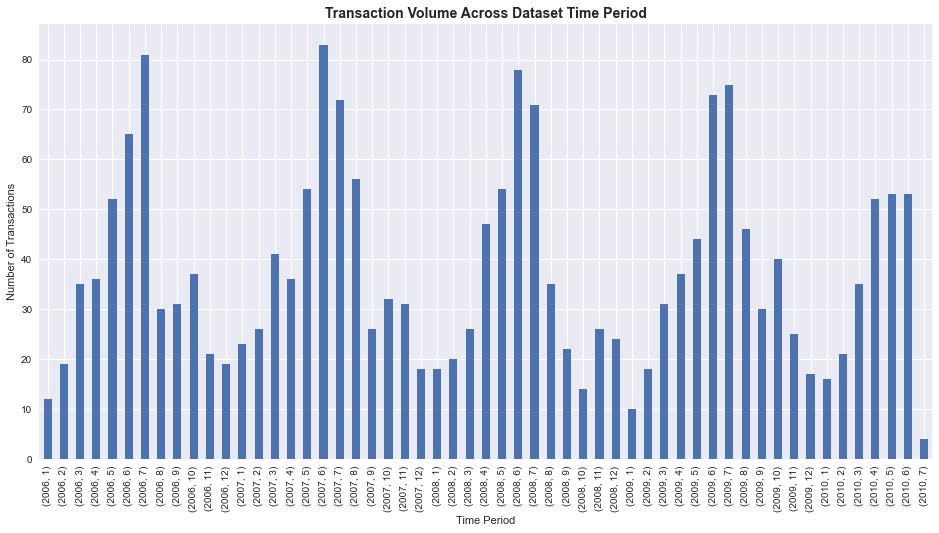

In [36]:
plt.figure(figsize=(16, 8))
# group by year and month and counting the number of transactions that occurred
ax = ames.groupby(['Yr Sold', 'Mo Sold']).Id.count().plot(kind='bar')
ax.set_title('Transaction Volume Across Dataset Time Period', fontsize=14, fontweight='bold')
ax.set_xlabel('Time Period')
ax.set_ylabel('Number of Transactions')
plt.show()

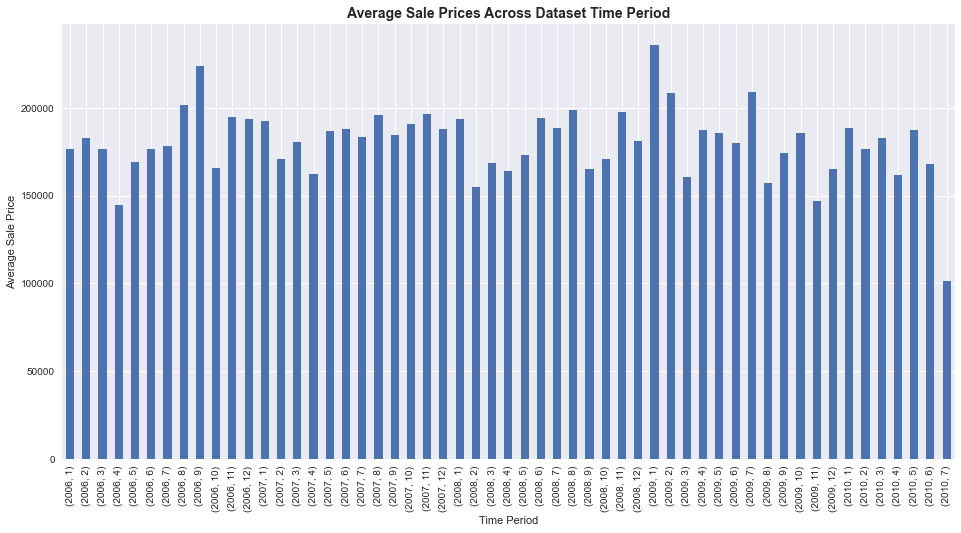

In [37]:
plt.figure(figsize=(16, 8))
ax = ames.groupby(['Yr Sold', 'Mo Sold']).SalePrice.mean().plot(kind='bar')
ax.set_title('Average Sale Prices Across Dataset Time Period', fontsize=14, fontweight='bold')
ax.set_xlabel('Time Period')
ax.set_ylabel('Average Sale Price')
plt.show()

Ames generally see higher house transactions during the summer evidenced by the much higher bars in May to July across the years. Perhaps affected by the US subprime crisis, number of transactions in 2010, especially during the summer, was markedly lower. <br>

Nonetheless, we see average sale prices remaining largely uniform over the years, remaining robust albeit with a slight dip in 2010. This could indicate that housing prices in Ames might be resilient to the subprime crisis.  

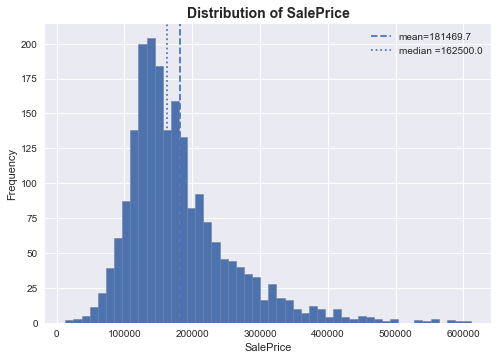

In [38]:
column = 'SalePrice'
plt.hist(ames[column], edgecolor='slategray', linewidth=0.5, bins=50)
# identify the mean and median
plt.axvline(ames[column].mean(), label=f'mean={round(ames[column].mean(),1)}', ls='--')
plt.axvline(ames[column].median(), label=f'median ={round(ames[column].median(),1)}', ls=':')
plt.title(f'Distribution of {column}', fontsize=14, fontweight='bold')
plt.legend()
plt.xlabel(column)
plt.ylabel('Frequency')
plt.show()

The SalePrice is right skew, evident from the number of extreme large values in SalePrice as well as the mean significantly larger than its median. We also notice a very low minimum and high maximum sale prices so let's investigate this in more detail:

In [39]:
ames.loc[ames['SalePrice']<30000]

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
183   1554  910251050           20   A (agr)          80.0     14584   Pave   
1628   182  902207130           30        RM          68.0      9656   Pave   

     Alley Lot Shape Land Contour Utilities Lot Config Land Slope  \
183     NA       Reg          Low    AllPub     Inside        Mod   
1628    NA       Reg          Lvl    AllPub     Inside        Gtl   

     Neighborhood Condition 1 Condition 2 Bldg Type House Style  Overall Qual  \
183        IDOTRR        Norm        Norm      1Fam      1Story             1   
1628      OldTown        Norm        Norm      1Fam      1Story             2   

      Overall Cond  Year Built  Year Remod/Add Roof Style Roof Matl  \
183              5        1952            1952      Gable   CompShg   
1628             2        1923            1970      Gable   CompShg   

     Exterior 1st Exterior 2nd Mas Vnr Type  Mas Vnr Area Exter Qual  \
183       AsbShng      VinylSd         None           0.0         Fa   
1628      AsbShng      AsbShng         None           0.0         TA   

     Exter Cond Foundation Bsmt Qual Bsmt Cond Bsmt Exposure BsmtFin Type 1  \
183          Po       Slab        NA        NA            NA             NA   
1628         Fa     BrkTil        Fa        Fa            No            Unf   

      BsmtFin SF 1 BsmtFin Type 2  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  \
183            0.0             NA           0.0          0.0            0.0   
1628           0.0            Unf           0.0        678.0          678.0   

     Heating Heating QC Central Air Electrical  1st Flr SF  2nd Flr SF  \
183     Wall         Po           N      FuseA         733           0   
1628    GasA         TA           N      SBrkr         832           0   

      Low Qual Fin SF  Gr Liv Area  Bsmt Full Bath  Bsmt Half Bath  Full Bath  \
183                 0          733             0.0             0.0          1   
1628                0          832             0.0             0.0          1   

      Half Bath  Bedroom AbvGr  Kitchen AbvGr Kitchen Qual  TotRms AbvGrd  \
183           0              2              1           Fa              4   
1628          0              2              1           TA              5   

     Functional  Fireplaces Fireplace Qu Garage Type  Garage Yr Blt  \
183         Sal           0           NA      Attchd         1952.0   
1628        Typ           1           Gd      Detchd         1928.0   

     Garage Finish  Garage Cars  Garage Area Garage Qual Garage Cond  \
183            Unf          2.0        487.0          Fa          Po   
1628           Unf          2.0        780.0          Fa          Fa   

     Paved Drive  Wood Deck SF  Open Porch SF  Enclosed Porch  3Ssn Porch  \
183            N             0              0               0           0   
1628           N             0              0               0           0   

      Screen Porch  Pool Area Pool QC Fence Misc Feature  Misc Val  Mo Sold  \
183              0          0      NA    NA           NA         0        2   
1628             0          0      NA    NA           NA         0        6   

      Yr Sold Sale Type  SalePrice  
183      2008       WD       13100  
1628     2010       WD       12789

We suspect that this could be an abnormal sale or a distressed sale due to the extreme low price despite the relatively large lot area. Hence, we shall drop them from our data:

In [40]:
# dropping the 2 houses from our data and subsequently reset the index based on 2049 houses
ames.drop([183, 1628], inplace=True,)
ames.reset_index(drop=True, inplace=True)

In [41]:
ames.loc[ames['SalePrice']>500000]

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
81     367  527214050           20        RL          63.0     17423   Pave   
138   2331  527210040           60        RL          60.0     18062   Pave   
151   2333  527212030           60        RL          85.0     16056   Pave   
622    457  528176030           20        RL         100.0     14836   Pave   
799   1702  528118050           20        RL          59.0     17169   Pave   
822     16  527216070           60        RL          47.0     53504   Pave   
1163   424  528106020           20        RL         105.0     15431   Pave   
1591  2335  527214060           60        RL          82.0     16052   Pave   
1669    45  528150070           20        RL         100.0     12919   Pave   
1690  2451  528360050           60        RL         114.0     17242   Pave   
1794   434  528110090           60        RL         107.0     13891   Pave   
1962  1638  527216080           20        RL          52.0     51974   Pave   

     Alley Lot Shape Land Contour Utilities Lot Config Land Slope  \
81      NA       IR1          Lvl    AllPub    CulDSac        Gtl   
138     NA       IR1          HLS    AllPub    CulDSac        Gtl   
151     NA       IR1          Lvl    AllPub     Inside        Gtl   
622     NA       IR1          HLS    AllPub     Inside        Mod   
799     NA       IR2          Lvl    AllPub    CulDSac        Gtl   
822     NA       IR2          HLS    AllPub    CulDSac        Mod   
1163    NA       Reg          Lvl    AllPub     Inside        Gtl   
1591    NA       IR1          Lvl    AllPub    CulDSac        Gtl   
1669    NA       IR1          Lvl    AllPub     Inside        Gtl   
1690    NA       IR1          Lvl    AllPub     Inside        Gtl   
1794    NA       Reg          Lvl    AllPub     Inside        Gtl   
1962    NA       IR1          Lvl    AllPub    CulDSac        Gtl   

     Neighborhood Condition 1 Condition 2 Bldg Type House Style  Overall Qual  \
81        Gilbert        Norm        Norm      1Fam      1Story             9   
138       Gilbert        Norm        Norm      1Fam      2Story            10   
151       Gilbert        Norm        Norm      1Fam      2Story             9   
622       NridgHt        Norm        Norm      1Fam      1Story            10   
799       NridgHt        Norm        Norm      1Fam      1Story            10   
822       Gilbert        Norm        Norm      1Fam      2Story             8   
1163      NridgHt        Norm        Norm      1Fam      1Story            10   
1591      Gilbert        Norm        Norm      1Fam      2Story            10   
1669      NridgHt        Norm        Norm      1Fam      1Story             9   
1690      NoRidge        Norm        Norm      1Fam      2Story             9   
1794      NridgHt        Norm        Norm      1Fam      2Story             9   
1962      Gilbert        PosN        Norm      1Fam      1Story             9   

      Overall Cond  Year Built  Year Remod/Add Roof Style Roof Matl  \
81               5        2008            2009        Hip   CompShg   
138              5        2006            2006        Hip   CompShg   
151              5        2005            2006        Hip   CompShg   
622              5        2004            2005        Hip   CompShg   
799              5        2007            2007        Hip   CompShg   
822              5        2003            2003        Hip   CompShg   
1163             5        2008            2008        Hip   CompShg   
1591             5        2006            2006        Hip   CompShg   
1669             5        2009            2010        Hip   CompShg   
1690             5        1993            1994        Hip   CompShg   
1794             5        2008            2009        Hip   CompShg   
1962             5        2006            2007        Hip   CompShg   

     Exterior 1st Exterior 2nd Mas Vnr Type  Mas Vnr Area Exter Qual  \
81        VinylSd      VinylSd  

Conversely, these sale prices are for relatively large and new houses with excellent quality ratings. Such houses should fetch a premium due to their scarcity and thus, we will not be dropping these houses. <br>

Additionally, due to the right skew of the SalePrice distribution, we would like to take the natural log of SalePrice so that the distribution will be more normal and better prediction / inferences can be glean from it:

In [42]:
ames['SalePrice'] = np.log(ames['SalePrice'])

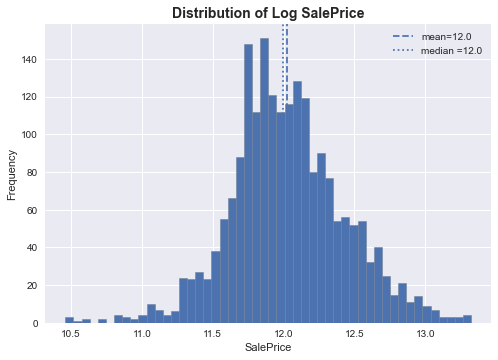

In [43]:
column = 'SalePrice'
plt.hist(ames[column], edgecolor='slategray', linewidth=0.5, bins=50)
plt.axvline(ames[column].mean(), label=f'mean={round(ames[column].mean(),1)}', ls='--')
plt.axvline(ames[column].median(), label=f'median ={round(ames[column].median(),1)}', ls=':')
plt.title(f'Distribution of Log {column}', fontsize=14, fontweight='bold')
plt.legend()
plt.xlabel(column)
plt.ylabel('Frequency')
plt.show()

Our mean and median are approximately equal now and the shape of the distribution is more normal after the natural log transformation. 

## Exploring Categorical Features

Next, let us briefly look at all the columns and refer back to the data dictionary to see if the values in the cells make sense. But first, we would also like to be more effective with our end goal in mind. As we glean through the features, we would like to pick out features that we feel will be important in determining the sale price, as well as group some of these features together if they roughly describe the same thing.<br>

We will start with the qualitative data first and as we cycle through each feature, we make reference to the data dictionary, plot the boxplot of the feature in relation to SalePrice and decide if the feature can help us to better explain SalePrice, if it doesn't, we will drop the feature. The columns we are left with will be the features we would like to use in our model: <br>

Let us first create a copy of our main dataframe so that we can always retrieve any features we drop should there be a need to: 

In [44]:
# creating a dataframe from ames, using .copy so that what we do to X will not affect
# our original dataframe, ames
X = ames.copy()

Let us first look at MS subclass, Bldg Type, House Style:

In [45]:
print(X['MS SubClass'].dtype)
X['MS SubClass'].value_counts()

int64


20     769
60     394
50     198
120    132
30     100
70      90
160     88
80      86
90      75
190     46
85      28
75      16
45      11
180     11
40       4
150      1
Name: MS SubClass, dtype: int64

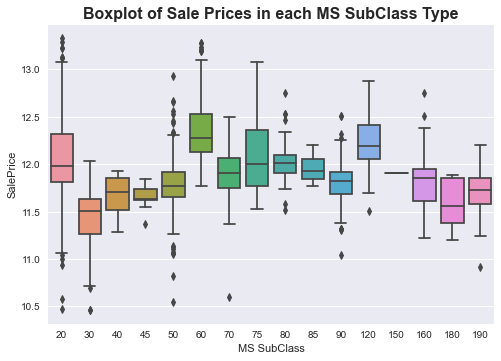

In [46]:
ax = sns.boxplot(x='MS SubClass', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each MS SubClass Type', fontsize='16', fontweight='bold');

Let's look at the description for MS SubClass:
Identifies the type of dwelling involved in the sale.	

       020	1-STORY 1946 & NEWER ALL STYLES
       030	1-STORY 1945 & OLDER
       040	1-STORY W/FINISHED ATTIC ALL AGES
       045	1-1/2 STORY - UNFINISHED ALL AGES
       050	1-1/2 STORY FINISHED ALL AGES
       060	2-STORY 1946 & NEWER
       070	2-STORY 1945 & OLDER
       075	2-1/2 STORY ALL AGES
       080	SPLIT OR MULTI-LEVEL
       085	SPLIT FOYER
       090	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

We see the descriptions are mainly the same for some of these features which can be combined, especially for those with low frequency into those in high frequency of similar classes. <br>
Specifically:<br>

    040, 045, 150 into 050 
    085, 180 into 080
    160 into 070
    120 into 020
    075, 190 into 090

With the combination, we will be left with the following classes:

       020	1-STORY 1946 & NEWER ALL STYLES
       030	1-STORY 1945 & OLDER
       050	1-1/2 STORY FINISHED ALL AGES
       060	2-STORY 1946 & NEWER
       070	2-STORY 1945 & OLDER
       075	2-1/2 STORY ALL AGES
       080	SPLIT OR MULTI-LEVEL
       090	DUPLEX - ALL STYLES AND AGES

Firstly, since this is a nominal data, we change the datatype into a string:

In [47]:
X['MS SubClass'] = X['MS SubClass'].astype('str')

In [48]:
subclass_convert = {'40': '50', '45': '50', '150': '50',
                    '85': '80', '180': '80', '160': '70',
                    '120': '20', '75': '90', '190': '90'}
X['MS SubClass'].replace(subclass_convert, inplace=True)

In [49]:
# check and look at spread of frequency and values after conversion
print(X['MS SubClass'].dtype)
X['MS SubClass'].value_counts()

object


20    901
60    394
50    214
70    178
90    137
80    125
30    100
Name: MS SubClass, dtype: int64

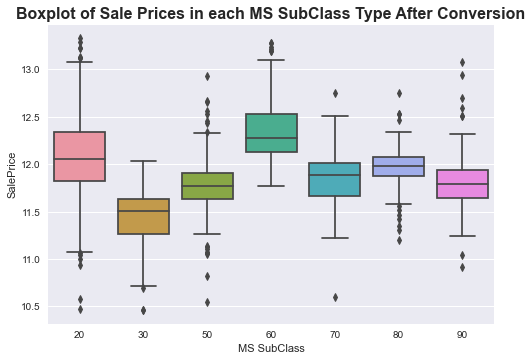

In [50]:
ax = sns.boxplot(x='MS SubClass', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each MS SubClass Type After Conversion', fontsize='16', fontweight='bold');

In [51]:
print(X['Bldg Type'].dtypes)
X['Bldg Type'].value_counts()

object


1Fam      1698
TwnhsE     161
Duplex      75
Twnhs       69
2fmCon      46
Name: Bldg Type, dtype: int64

In [52]:
print(X['House Style'].dtypes)
X['House Style'].value_counts()

object


1Story    1057
2Story     598
1.5Fin     218
SLvl        94
SFoyer      50
2.5Unf      14
1.5Unf      12
2.5Fin       6
Name: House Style, dtype: int64

Since Bldg Type and House Style contain information about the same underlying points, and MS SubClass has more variance across the categories, we will use MS SubClass and drop the rest:

In [53]:
X.drop(['Bldg Type', 'House Style'], axis=1, inplace=True)

Let's look at MS Zone next:

In [54]:
print(X['MS Zoning'].dtypes)
X['MS Zoning'].value_counts()

object


RL         1598
RM          315
FV          101
C (all)      19
RH           14
I (all)       1
A (agr)       1
Name: MS Zoning, dtype: int64

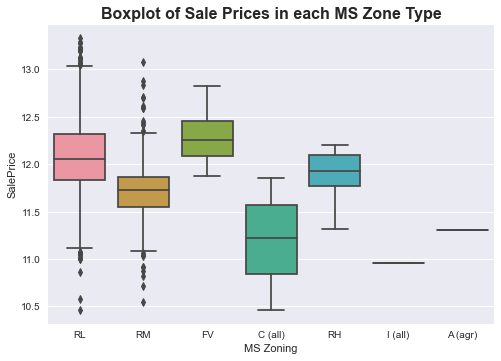

In [55]:
ax = sns.boxplot(x='MS Zoning', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each MS Zone Type', fontsize='16', fontweight='bold');

We see that RL (Residential Low Density), RM (Residential Mid Density) and FV (Floating Village Residential) have the highest frequency, while C (all) (Commercial), RH (Residential High Density), Agr (Agriculture), I(all) (Industrial) have relatively low frequency. We could perhaps group RH into RM and the rest as an 'Others' category: 

In [56]:
zoning_convert = {'C (all)': 'Others', 'I (all)': 'Others', 'A (agr)': 'Others',
                  'RH': 'RM'}
X['MS Zoning'].replace(zoning_convert, inplace=True)

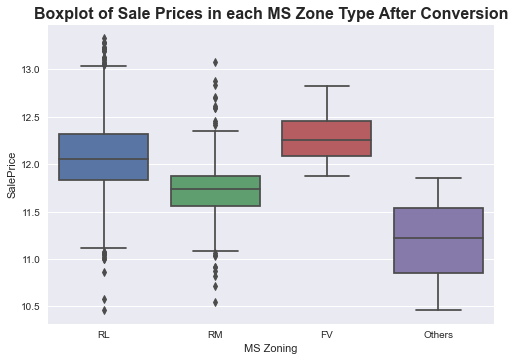

In [57]:
ax = sns.boxplot(x='MS Zoning', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each MS Zone Type After Conversion', fontsize='16', fontweight='bold');

We look at Street and Alley next:

In [58]:
print(X['Street'].dtypes)
X['Street'].value_counts()

object


Pave    2042
Grvl       7
Name: Street, dtype: int64

In [59]:
print(X['Alley'].dtypes)
X['Alley'].value_counts()

object


NA      1909
Grvl      85
Pave      55
Name: Alley, dtype: int64

Both are significantly distributed into one category and hence there would be little information with in feature to explain SalePrice. Hence we will drop these:

In [60]:
X.drop(['Street', 'Alley'], axis=1, inplace=True)

We move on to Lot Shape, Lot Config:

In [61]:
print(X['Lot Shape'].dtypes)
X['Lot Shape'].value_counts()

object


Reg    1293
IR1     692
IR2      55
IR3       9
Name: Lot Shape, dtype: int64

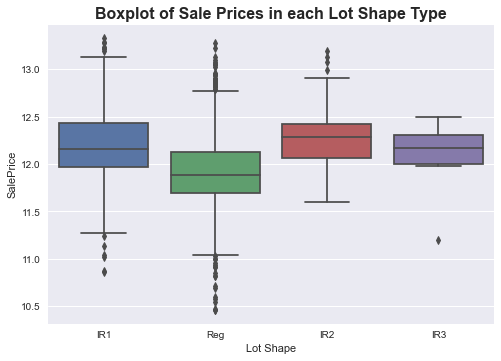

In [62]:
ax = sns.boxplot(x='Lot Shape', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Lot Shape Type', fontsize='16', fontweight='bold');

Since it is Regular vs different degree of Irregular, let's combine them into 'Reg' and 'Irr':

In [63]:
lot_shape_convert = {'IR1': 'Irr', 'IR2': 'Irr', 'IR3': 'Irr'}
X['Lot Shape'].replace(lot_shape_convert, inplace=True)

In [64]:
print(X['Lot Config'].dtypes)
X['Lot Config'].value_counts()

object


Inside     1501
Corner      348
CulDSac     131
FR2          60
FR3           9
Name: Lot Config, dtype: int64

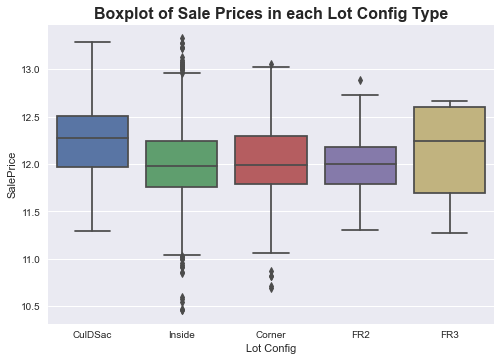

In [65]:
ax = sns.boxplot(x='Lot Config', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Lot Config Type', fontsize='16', fontweight='bold');

Likewise, since it is single lots vs different types of non-inside lots, we convert them into 'Inside' and 'Others':

In [66]:
lot_config_convert = {'CulDSac': 'Others', 'Corner': 'Others', 
                      'FR2': 'Others', 'FR3': 'Others'}
X['Lot Config'].replace(lot_config_convert, inplace=True)

Let's look at Land Contour and Land Slope next:

In [67]:
print(X['Land Contour'].dtypes)
X['Land Contour'].value_counts()

object


Lvl    1842
HLS      85
Bnk      80
Low      42
Name: Land Contour, dtype: int64

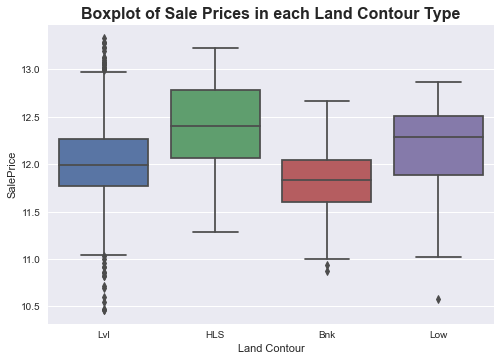

In [68]:
ax = sns.boxplot(x='Land Contour', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Land Contour Type', fontsize='16', fontweight='bold');

Similarly, we can group them into 'Lvl' (level) contours vs 'Others' (non-level):

In [69]:
land_contour_convert = {'HLS': 'Others', 'Bnk': 'Others', 'Low': 'Others'}
X['Land Contour'].replace(land_contour_convert, inplace=True)

In [70]:
print(X['Land Slope'].dtypes)
X['Land Slope'].value_counts()

object


Gtl    1952
Mod      87
Sev      10
Name: Land Slope, dtype: int64

Since it has the same type of information as Land Contour and Land Contour has more variety in the different categories, we drop Land Slope:

In [71]:
X.drop('Land Slope', axis=1, inplace=True)

Let's look at Utilities, Condition 1, Condition 2:

In [72]:
print(X['Utilities'].dtypes)
X['Utilities'].value_counts()

object


AllPub    2047
NoSewr       1
NoSeWa       1
Name: Utilities, dtype: int64

In [73]:
print(X['Condition 2'].dtypes)
X['Condition 2'].value_counts()

object


Norm      2023
Feedr       11
Artery       5
PosA         3
PosN         3
RRNn         2
RRAe         1
RRAn         1
Name: Condition 2, dtype: int64

We drop Utilities and Condition 2 as they do not offer much information for SalePrices in other categories:

In [74]:
X.drop(['Utilities', 'Condition 2'], axis=1, inplace=True)

In [75]:
print(X['Condition 1'].dtypes)
X['Condition 1'].value_counts()

object


Norm      1765
Feedr      109
Artery      70
RRAn        36
PosN        27
RRAe        21
PosA        12
RRNn         6
RRNe         3
Name: Condition 1, dtype: int64

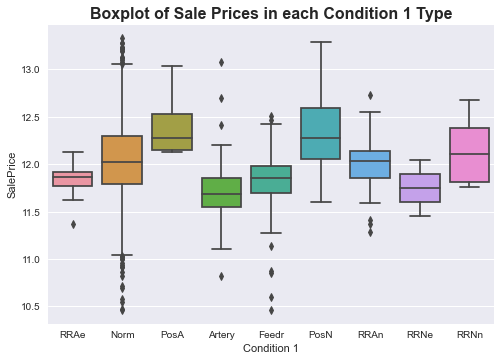

In [76]:
ax = sns.boxplot(x='Condition 1', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Condition 1 Type', fontsize='16', fontweight='bold');

From the data documentation, we see 2 of these conditions are positive:

       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
So we can group Condition 1 into 'Norm', 'Positive' and 'Others':

In [77]:
cond_1_convert={'Feedr': 'Others', 'Artery': 'Others', 'RRAn': 'Others',
                'PosN': 'Positive', 'RRAe': 'Others', 'PosA': 'Positive',
                'RRNn': 'Others', 'RRNe': 'Others'}

X['Condition 1'].replace(cond_1_convert, inplace=True)

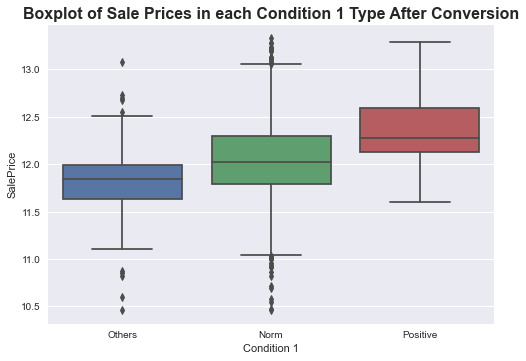

In [78]:
# check
ax = sns.boxplot(x='Condition 1', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Condition 1 Type After Conversion', fontsize='16', fontweight='bold');

We look at Overall Qual and Overall Cond next:

In [79]:
print(X['Overall Qual'].dtypes)
X['Overall Qual'].value_counts()

int64


5     563
6     506
7     431
8     250
4     159
9      77
3      29
10     23
2       8
1       3
Name: Overall Qual, dtype: int64

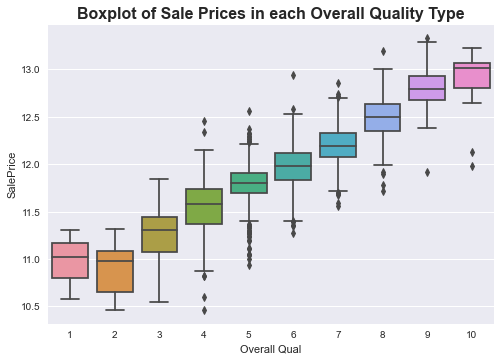

In [80]:
ax = sns.boxplot(x='Overall Qual', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Overall Quality Type', fontsize='16', fontweight='bold');

We see that SalePrice shows a distinction for each quality grade, however we suspect there might not be much differences in Quality of 1 and 2 and since the datapoints are so few in those 2 categories, we combine them and convert everything into a 9-point scale:

In [81]:
overall_qual_convert={2: 1, 3: 2, 4: 3,
                      5: 4, 6: 5, 7: 6,
                      8: 7, 9: 8, 10: 9}

X['Overall Qual'].replace(overall_qual_convert, inplace=True)

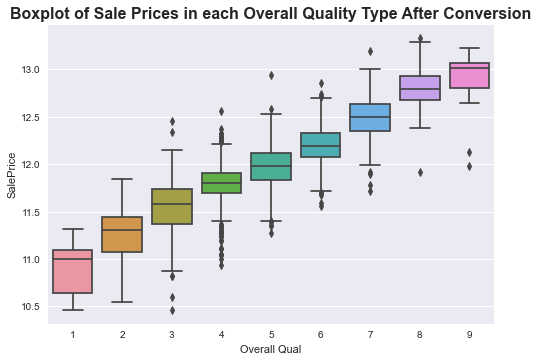

In [82]:
# Check
ax = sns.boxplot(x='Overall Qual', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Overall Quality Type After Conversion', fontsize='16', fontweight='bold');

In [83]:
print(X['Overall Cond'].dtypes)
X['Overall Cond'].value_counts()

int64


5    1167
6     368
7     270
8     101
4      70
3      35
9      29
2       5
1       4
Name: Overall Cond, dtype: int64

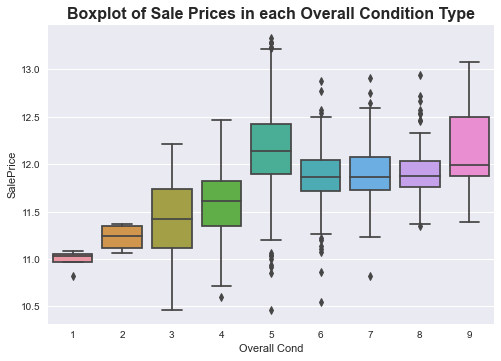

In [84]:
ax = sns.boxplot(x='Overall Cond', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Overall Condition Type', fontsize='16', fontweight='bold');

Meanwhile for Overall condition, the range of category 5 seems to dominate the rest. Also, SalePrice does not show a clear distinction across the categories. Hence, we decide to drop this feature:

In [85]:
X.drop('Overall Cond', axis=1, inplace=True)

In [86]:
print(X['Roof Style'].dtypes)
X['Roof Style'].value_counts()

object


Gable      1617
Hip         397
Flat         13
Gambrel      12
Mansard       7
Shed          3
Name: Roof Style, dtype: int64

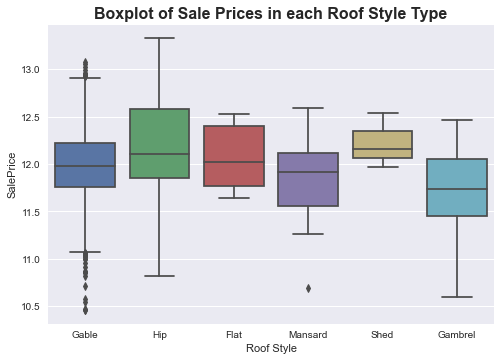

In [87]:
ax = sns.boxplot(x='Roof Style', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Roof Style Type', fontsize='16', fontweight='bold');

In [88]:
print(X['Roof Matl'].dtypes)
X['Roof Matl'].value_counts()

object


CompShg    2023
Tar&Grv      15
WdShngl       5
WdShake       4
ClyTile       1
Membran       1
Name: Roof Matl, dtype: int64

For Roof Styles, as the 2 most dominant categories 'Gable' and 'Hip' do not show much variance, we decide to drop it. <br>
Likewise, for Roof Matl, almost all data points are in one category, hence we drop this as well:

In [89]:
X.drop(['Roof Style', 'Roof Matl'], axis=1, inplace=True)

In [90]:
print(X['Exterior 1st'].dtypes)
X['Exterior 1st'].value_counts()

object


VinylSd    724
MetalSd    331
HdBoard    300
Wd Sdng    276
Plywood    152
CemntBd     90
BrkFace     64
WdShing     45
AsbShng     31
Stucco      27
BrkComm      3
CBlock       2
Stone        2
ImStucc      1
AsphShn      1
Name: Exterior 1st, dtype: int64

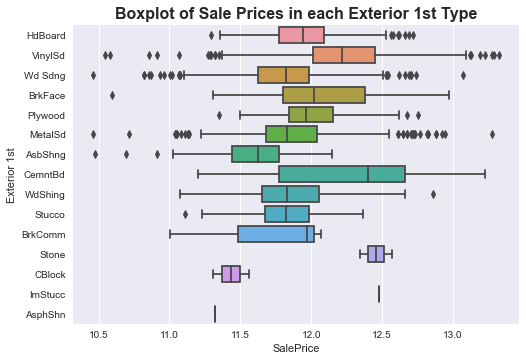

In [91]:
ax = sns.boxplot(y='Exterior 1st', x='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Exterior 1st Type', fontsize='16', fontweight='bold');

In [92]:
print(X['Exterior 2nd'].dtypes)
X['Exterior 2nd'].value_counts()

object


VinylSd    720
MetalSd    324
HdBoard    275
Wd Sdng    262
Plywood    185
CmentBd     90
Wd Shng     63
BrkFace     34
Stucco      30
AsbShng     27
Brk Cmn     17
ImStucc     11
Stone        6
AsphShn      3
CBlock       2
Name: Exterior 2nd, dtype: int64

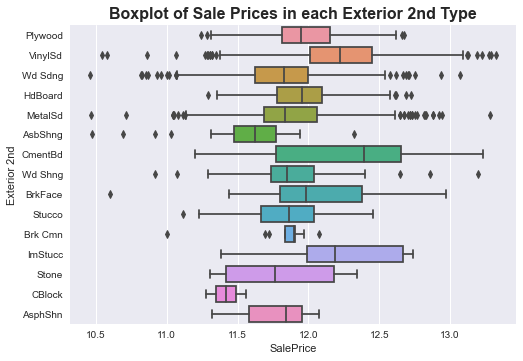

In [93]:
ax = sns.boxplot(y='Exterior 2nd', x='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Exterior 2nd Type', fontsize='16', fontweight='bold');

As we do not see a distinct trend / difference for us to include this, we decided to exclude these 2 features:

In [94]:
X.drop(['Exterior 1st', 'Exterior 2nd'], axis=1, inplace=True)

In [95]:
print(X['Mas Vnr Type'].dtypes)
X['Mas Vnr Type'].value_counts()

object


None       1216
BrkFace     630
Stone       168
NA           22
BrkCmn       13
Name: Mas Vnr Type, dtype: int64

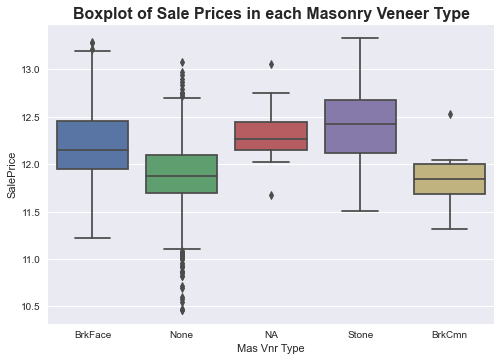

In [96]:
ax = sns.boxplot(x='Mas Vnr Type', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Masonry Veneer Type', fontsize='16', fontweight='bold');

We can make this into a binary type of feature, whereby houses either have Masonry Veneer or they do not have Masonry Veneer. We also notice that we have 2 categories for none (None and NA) which we will correct:

In [97]:
# similarly, Data Documentation has 5 types, including None. we include all 5 types in our conversion dictionary
mas_vnr_convert={'BrkFace': 'Present', 'NA': 'None', 
                 'Stone': 'Present', 'BrkCmn': 'Present',
                 'CBlock': 'Present'}

X['Mas Vnr Type'].replace(mas_vnr_convert, inplace=True)

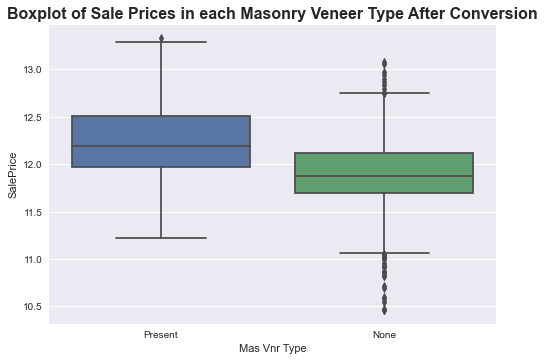

In [98]:
# check
ax = sns.boxplot(x='Mas Vnr Type', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Masonry Veneer Type After Conversion', fontsize='16', fontweight='bold');

In [99]:
print(X['Exter Qual'].dtypes)
X['Exter Qual'].value_counts()

object


TA    1246
Gd     697
Ex      81
Fa      25
Name: Exter Qual, dtype: int64

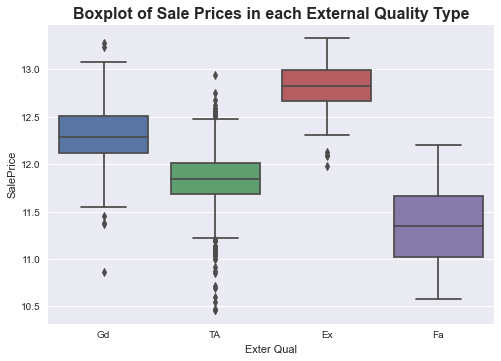

In [100]:
ax = sns.boxplot(x='Exter Qual', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each External Quality Type', fontsize='16', fontweight='bold');

As Exter Qual (External Quality) is an ordinal type of data, let's convert it to a numerical scale, also the data documentation reveals that there are 5 categories, including Po (Poor), hence we will convert it to a 5-number scale:

In [101]:
ext_qual_convert = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
X['Exter Qual'].replace(ext_qual_convert, inplace=True)

In [102]:
# check the dtype
X['Exter Qual'].dtypes

dtype('int64')

In [103]:
print(X['Exter Cond'].dtypes)
X['Exter Cond'].value_counts()

object


TA    1778
Gd     215
Fa      48
Ex       7
Po       1
Name: Exter Cond, dtype: int64

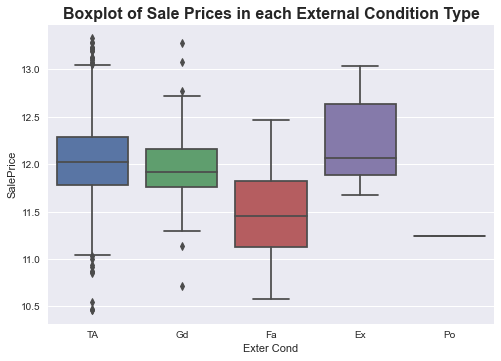

In [104]:
ax = sns.boxplot(x='Exter Cond', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each External Condition Type', fontsize='16', fontweight='bold');

Similar to Overall Condition, we see TA: typical dominating the rest of the other categories and do not see clear distinction for SalePrice. <br>
Decision: do not include in model:

In [105]:
X.drop('Exter Cond', axis=1, inplace=True)

In [106]:
print(X['Foundation'].dtypes)
X['Foundation'].value_counts()

object


PConc     926
CBlock    863
BrkTil    220
Slab       33
Stone       5
Wood        2
Name: Foundation, dtype: int64

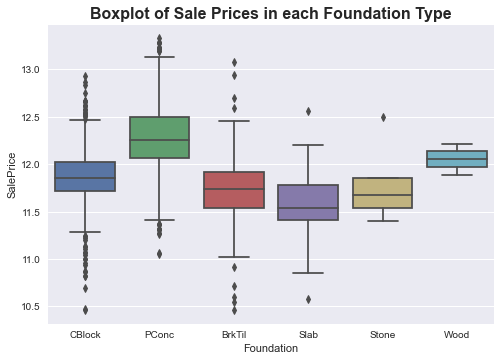

In [107]:
ax = sns.boxplot(x='Foundation', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Foundation Type', fontsize='16', fontweight='bold');

Let's convert them into 3 types: 'PConc' (Poured Concrete), 'CBlock' (Cinder Block) and 'Others':

In [108]:
foundation_convert = {'BrkTil': 'Others', 'Slab': 'Others', 
                      'Stone': 'Others', 'Wood': 'Others'}
X['Foundation'].replace(foundation_convert, inplace=True)

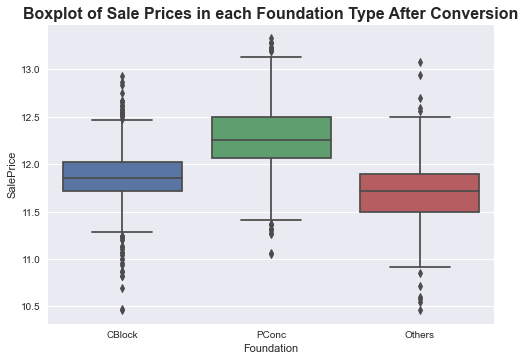

In [109]:
# Check
ax = sns.boxplot(x='Foundation', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Foundation Type After Conversion', fontsize='16', fontweight='bold');

In [110]:
print(X['Bsmt Qual'].dtypes)
X['Bsmt Qual'].value_counts()

object


TA    887
Gd    864
Ex    184
Fa     59
NA     54
Po      1
Name: Bsmt Qual, dtype: int64

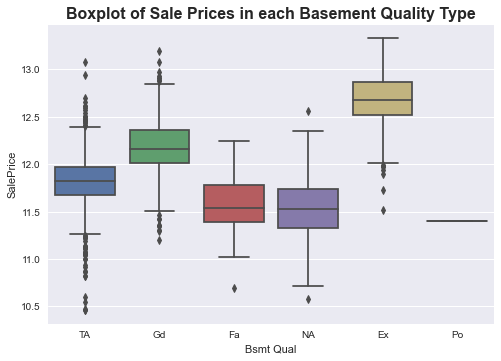

In [111]:
ax = sns.boxplot(x='Bsmt Qual', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Basement Quality Type', fontsize='16', fontweight='bold');

There is a clear distinction in sale price for 'TA' 'Gd' and 'Ex' Quality but not much for 'Fa', 'NA' and 'Po'. We decide to convert them to a 4-point scale: 

In [112]:
bsmt_qual_convert = {'NA': 1, 'Po': 1, 'Fa': 1,
                     'TA': 2, 'Gd': 3, 'Ex': 4}
                      
X['Bsmt Qual'].replace(bsmt_qual_convert, inplace=True)

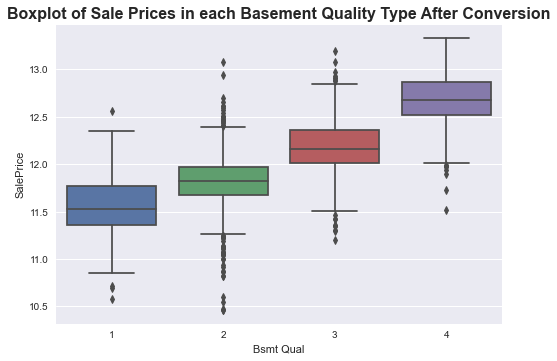

In [113]:
# Check
ax = sns.boxplot(x='Bsmt Qual', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Basement Quality Type After Conversion', fontsize='16', fontweight='bold');

In [114]:
print(X['Bsmt Cond'].dtypes)
X['Bsmt Cond'].value_counts()

object


TA    1834
Gd      89
Fa      64
NA      54
Po       5
Ex       3
Name: Bsmt Cond, dtype: int64

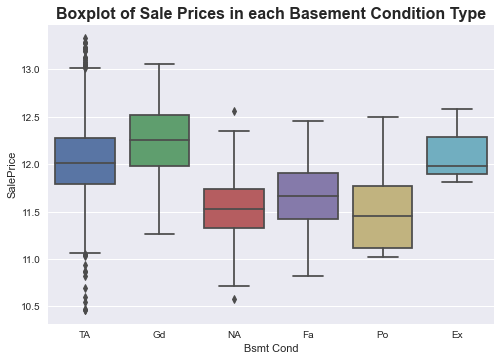

In [115]:
ax = sns.boxplot(x='Bsmt Cond', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Basement Condition Type', fontsize='16', fontweight='bold');

Similarly, due to the significant impact that TA has over the other categories, we shall drop Basement Condition:

In [116]:
X.drop('Bsmt Cond', axis=1, inplace=True)

In [117]:
print(X['Bsmt Exposure'].dtypes)
X['Bsmt Exposure'].value_counts()

object


No    1341
Av     288
Gd     203
Mn     163
NA      54
Name: Bsmt Exposure, dtype: int64

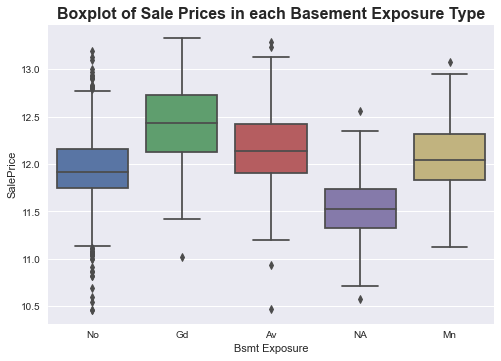

In [118]:
ax = sns.boxplot(x='Bsmt Exposure', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Basement Exposure Type', fontsize='16', fontweight='bold');

We also observe a good distinction of values across each category and convert these into a 5 point scale:

In [119]:
bsmt_exp_convert = {'NA': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
X['Bsmt Exposure'].replace(bsmt_exp_convert, inplace=True)

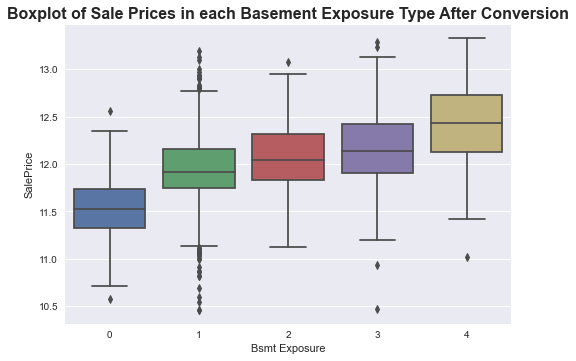

In [120]:
ax = sns.boxplot(x='Bsmt Exposure', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Basement Exposure Type After Conversion', fontsize='16', fontweight='bold');

In [121]:
print(X['BsmtFin Type 1'].dtypes)
X['BsmtFin Type 1'].value_counts()

object


GLQ    615
Unf    602
ALQ    293
BLQ    200
Rec    183
LwQ    102
NA      54
Name: BsmtFin Type 1, dtype: int64

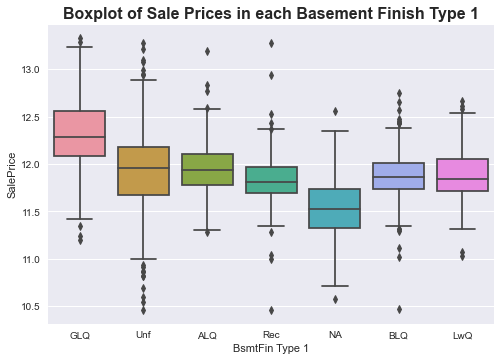

In [122]:
ax = sns.boxplot(x='BsmtFin Type 1', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Basement Finish Type 1', fontsize='16', fontweight='bold');

As we don't see a distinction in Unf (unfinished) compared to the rest except for NA and Good Living Condition, we will convert it into a 3-point scale:

In [123]:
bsmt_fin_convert = {'NA': 0, 'Unf': 1, 'LwQ': 1, 'Rec': 1, 'BLQ': 1, 'ALQ': 1, 'GLQ': 2}
X['BsmtFin Type 1'].replace(bsmt_fin_convert, inplace=True)

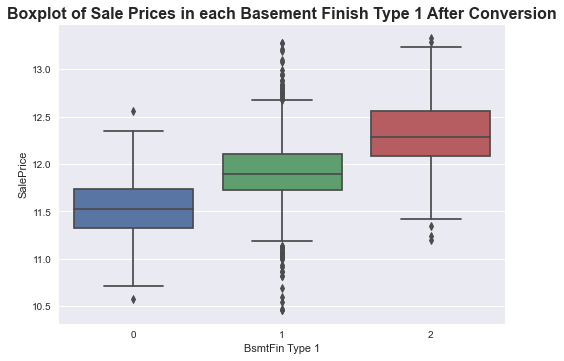

In [124]:
ax = sns.boxplot(x='BsmtFin Type 1', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Basement Finish Type 1 After Conversion', fontsize='16', fontweight='bold');

In [125]:
print(X['BsmtFin Type 2'].dtype)
X['BsmtFin Type 2'].value_counts() 

object


Unf    1748
Rec      80
LwQ      60
NA       54
BLQ      48
ALQ      36
GLQ      23
Name: BsmtFin Type 2, dtype: int64

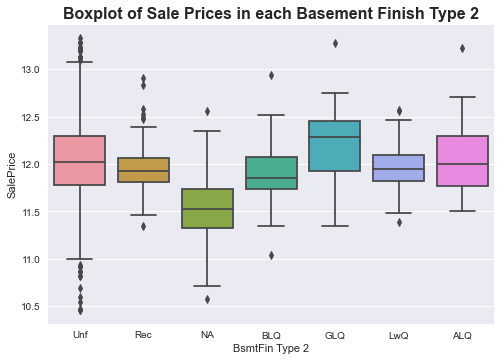

In [126]:
ax = sns.boxplot(x='BsmtFin Type 2', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Basement Finish Type 2', fontsize='16', fontweight='bold');

As we do not see a distinction in sale price in Unf (unfurnished) versus the other categories, we will drop this feature:

In [127]:
X.drop('BsmtFin Type 2', axis=1, inplace=True)

In [128]:
print(X['Heating'].dtype)
X['Heating'].value_counts()

object


GasA    2017
GasW      20
Wall       5
Grav       5
OthW       2
Name: Heating, dtype: int64

Since majority are GasA category, we will drop this feature:

In [129]:
X.drop('Heating', axis=1, inplace=True)

In [130]:
print(X['Heating QC'].dtype)
X['Heating QC'].value_counts()

object


Ex    1065
TA     596
Gd     319
Fa      67
Po       2
Name: Heating QC, dtype: int64

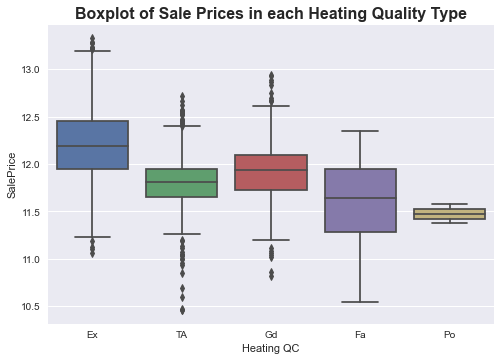

In [131]:
ax = sns.boxplot(x='Heating QC', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Heating Quality Type', fontsize='16', fontweight='bold');

Likewise, we convert this to a 5-point scale:

In [132]:
heating_qc_convert = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
X['Heating QC'].replace(heating_qc_convert, inplace=True)

In [133]:
print(X['Central Air'].dtype)
X['Central Air'].value_counts()

object


Y    1910
N     139
Name: Central Air, dtype: int64

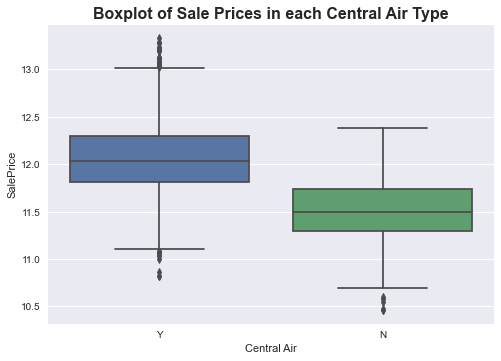

In [134]:
ax = sns.boxplot(x='Central Air', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Central Air Type', fontsize='16', fontweight='bold');

While majority of the values are in the Yes category, we do see a clear distinction in the sale prices in the 2 categories. Hence we will convert this to a dummy variable:

In [135]:
central_air_convert = {'Y': 1, 'N': 0}
X['Central Air'].replace(central_air_convert, inplace=True)

In [136]:
print(X['Electrical'].dtype)
X['Electrical'].value_counts()

object


SBrkr    1867
FuseA     139
FuseF      35
FuseP       7
Mix         1
Name: Electrical, dtype: int64

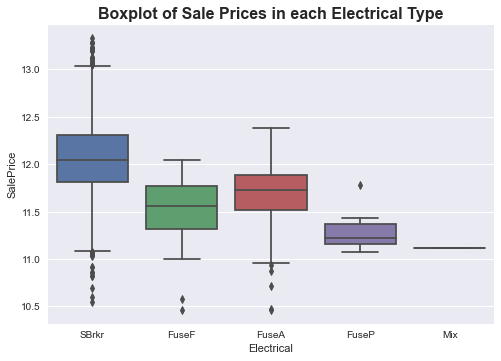

In [137]:
ax = sns.boxplot(x='Electrical', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Electrical Type', fontsize='16', fontweight='bold');

Similarly, as SBrkr (Standard Circuit Breaker) is dominant we do see a clear distinction versus the rest, we convert this into a binary category:

In [138]:
electrical_convert = {'SBrkr': 1, 'FuseF': 0, 'FuseA': 0, 'FuseP': 0, 'Mix': 0}
X['Electrical'].replace(electrical_convert, inplace=True)

In [139]:
print(X['Kitchen Qual'].dtype)
X['Kitchen Qual'].value_counts()

object


TA    1046
Gd     806
Ex     151
Fa      46
Name: Kitchen Qual, dtype: int64

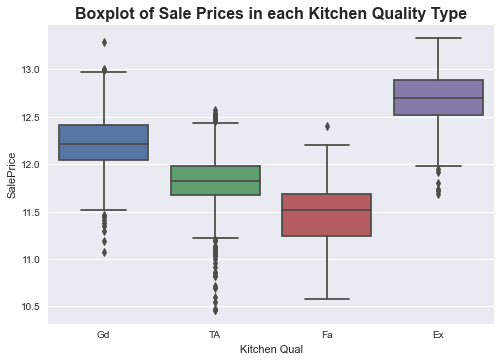

In [140]:
ax = sns.boxplot(x='Kitchen Qual', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Kitchen Quality Type', fontsize='16', fontweight='bold');

The Data Documentation includes a Po (Poor) category so we will include that category in our conversion:

In [141]:
kitchen_qual_convert = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
X['Kitchen Qual'].replace(kitchen_qual_convert, inplace=True)

In [142]:
print(X['Functional'].dtype)
X['Functional'].value_counts()

object


Typ     1914
Min1      42
Min2      42
Mod       29
Maj1      12
Maj2       7
Sev        2
Sal        1
Name: Functional, dtype: int64

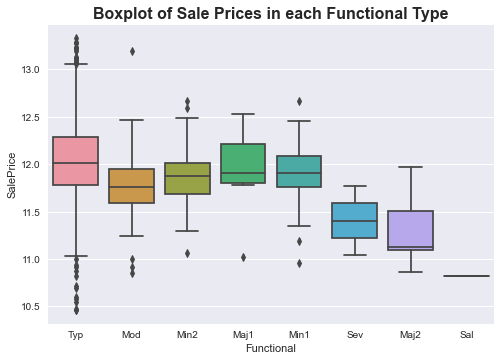

In [143]:
ax = sns.boxplot(x='Functional', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Functional Type', fontsize='16', fontweight='bold');

Despite Functional being an ordinal feature, we do not see a distinction in the ranking. For eg, Maj1 is supposed to rank worse than Min1 and Mod. Hence, we shall drop this feature.

In [144]:
X.drop('Functional', axis=1, inplace=True)

In [145]:
print(X['Fireplace Qu'].dtype)
X['Fireplace Qu'].value_counts()

object


NA    999
Gd    522
TA    407
Fa     59
Po     31
Ex     31
Name: Fireplace Qu, dtype: int64

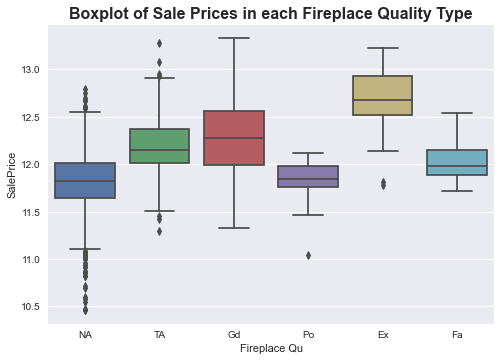

In [146]:
ax = sns.boxplot(x='Fireplace Qu', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Fireplace Quality Type', fontsize='16', fontweight='bold');

We do see a good spread of the sale price across the ordinal variables, hence we convert Fireplace Qu to a numerical scale:

In [147]:
fireplace_qu_convert = {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
X['Fireplace Qu'].replace(fireplace_qu_convert, inplace=True)

In [148]:
print(X['Garage Type'].dtype)
X['Garage Type'].value_counts()

object


Attchd     1212
Detchd      534
BuiltIn     132
NA          114
Basment      27
2Types       19
CarPort      11
Name: Garage Type, dtype: int64

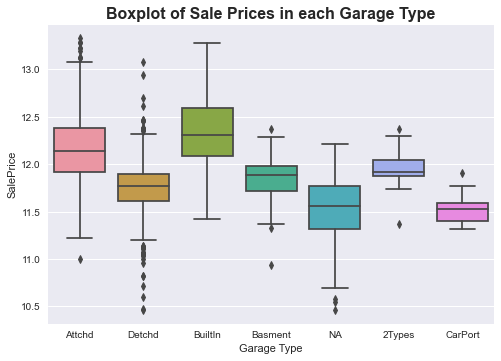

In [149]:
ax = sns.boxplot(x='Garage Type', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Garage Type', fontsize='16', fontweight='bold');

Since there is no clear distinction of sale price across the various categories, we shall drop this feature:

In [150]:
X.drop('Garage Type', axis=1, inplace=True)

In [151]:
print(X['Garage Finish'].dtype)
X['Garage Finish'].value_counts()

object


Unf    847
RFn    579
Fin    509
NA     114
Name: Garage Finish, dtype: int64

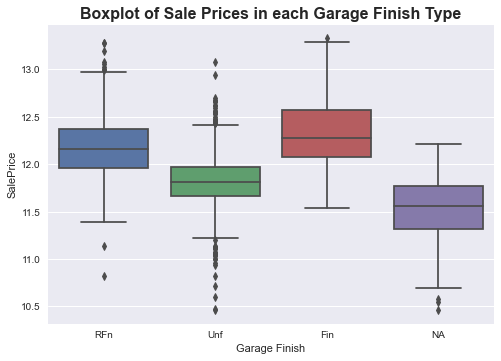

In [152]:
ax = sns.boxplot(x='Garage Finish', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Garage Finish Type', fontsize='16', fontweight='bold');

We do see some variety in sale price across the ordinal categories, so let's convert this to a numerical scale:

In [153]:
garage_fin_convert = {'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
X['Garage Finish'].replace(garage_fin_convert, inplace=True)

Let's look at Garage Quality and Garage Condition together next: 

In [154]:
print(X['Garage Qual'].dtype)
X['Garage Qual'].value_counts()

object


TA    1832
NA     114
Fa      80
Gd      18
Ex       3
Po       2
Name: Garage Qual, dtype: int64

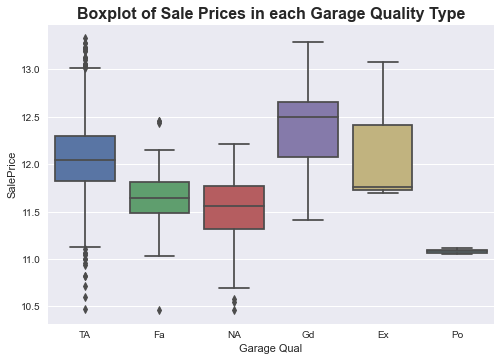

In [155]:
ax = sns.boxplot(x='Garage Qual', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Garage Quality Type', fontsize='16', fontweight='bold');

In [156]:
print(X['Garage Cond'].dtype)
X['Garage Cond'].value_counts()

object


TA    1868
NA     114
Fa      46
Gd      12
Po       7
Ex       2
Name: Garage Cond, dtype: int64

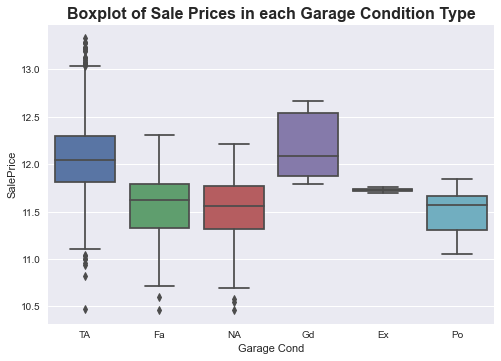

In [157]:
ax = sns.boxplot(x='Garage Cond', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Garage Condition Type', fontsize='16', fontweight='bold');

We see that TA (typical) domninates over the other categories and that Ex (excellent) is not better than Gd (good). Additionally, Garage Quality and Condition should be correlated to Garage Finish which we have already included, hence we will drop these 2 features:

In [158]:
X.drop(['Garage Qual', 'Garage Cond'], axis=1, inplace=True)

In [159]:
print(X['Paved Drive'].dtype)
X['Paved Drive'].value_counts()

object


Y    1861
N     149
P      39
Name: Paved Drive, dtype: int64

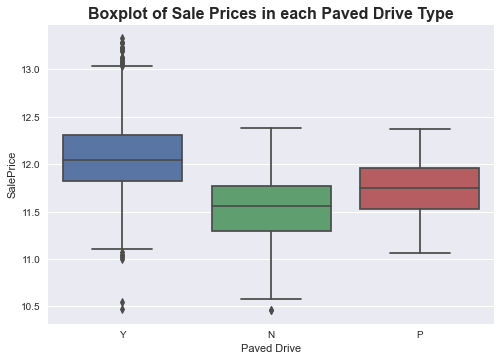

In [160]:
ax = sns.boxplot(x='Paved Drive', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Paved Drive Type', fontsize='16', fontweight='bold');

We feel there is not much difference between P (Partial Paved) and N (Dirt / Gravel). Hence, we shall convert this feature into a Binary, representing whether the driveway is paved (1) or not (0):

In [161]:
paved_drive_convert = {'N': 0, 'P': 0, 'Y': 1}
X['Paved Drive'].replace(paved_drive_convert, inplace=True)

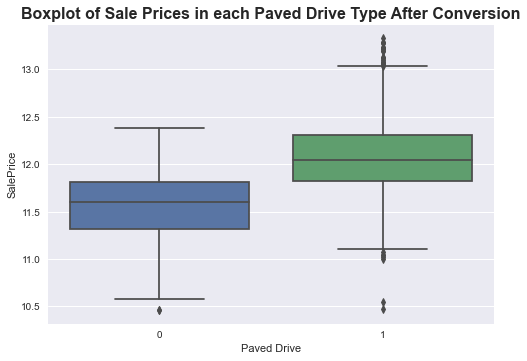

In [162]:
# Check
ax = sns.boxplot(x='Paved Drive', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Paved Drive Type After Conversion', fontsize='16', fontweight='bold');

In [163]:
print(X['Pool QC'].count())
X['Pool QC'].value_counts()

2049


NA    2040
Gd       4
TA       2
Fa       2
Ex       1
Name: Pool QC, dtype: int64

Since almost all houses do not have a pool, we will drop this feature:

In [164]:
X.drop('Pool QC', axis=1, inplace=True)

In [165]:
print(X['Fence'].dtype)
X['Fence'].value_counts()

object


NA       1649
MnPrv     227
GdPrv      83
GdWo       80
MnWw       10
Name: Fence, dtype: int64

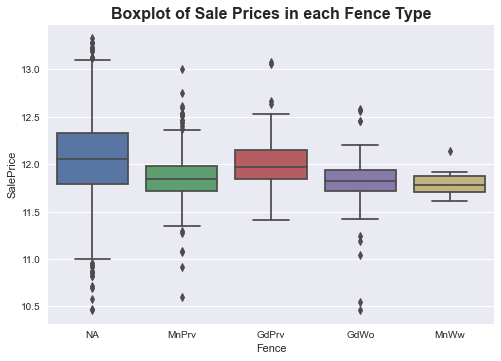

In [166]:
ax = sns.boxplot(x='Fence', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Fence Type', fontsize='16', fontweight='bold');

Houess with various types of fences do not show a distinction versus houess without fences, hence we drop this feature:

In [167]:
X.drop('Fence', axis=1, inplace=True)

In [168]:
print(X['Misc Feature'].dtype)
X['Misc Feature'].value_counts()

object


NA      1984
Shed      56
Gar2       4
Othr       3
TenC       1
Elev       1
Name: Misc Feature, dtype: int64

Since majority are NA, without any miscellaneous feature, we shall drop this:

In [169]:
X.drop('Misc Feature', axis=1, inplace=True)

In [170]:
print(X['Sale Type'].dtype)
X['Sale Type'].value_counts()

object


WD       1779
New       160
COD        63
ConLD      17
CWD        10
ConLI       7
ConLw       5
Con         4
Oth         4
Name: Sale Type, dtype: int64

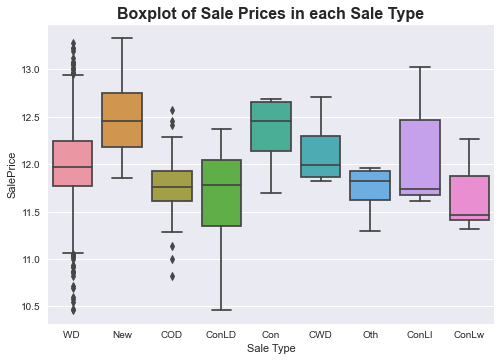

In [171]:
ax = sns.boxplot(x='Sale Type', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Sale Type', fontsize='16', fontweight='bold');

In [172]:
X['Sale Type'].unique()

array(['WD ', 'New', 'COD', 'ConLD', 'Con', 'CWD', 'Oth', 'ConLI',
       'ConLw'], dtype=object)

In Sale Type, we spot a particular category of interest - 'New', which the Data Document describe as 'Home just constructed and sold'. We believe that New Sales and Resales will be evaluated differently by buyers, hence we will convert this feature into 'new_sales' and 'resales', also we see that 'WD ' has been entered with a space:

In [173]:
# data documentation has 10 types, we only have 9 types here, we input the addition one as well
sale_type_convert = {'New': 'new_sales', 'WD ': 'resales', 'COD': 'resales',
                     'ConLD': 'resales', 'Con': 'resales', 'CWD': 'resales',
                     'Oth': 'resales', 'ConLI': 'resales', 'ConLw': 'resales',
                     'VWD': 'resales'}
X['Sale Type'].replace(sale_type_convert, inplace=True)

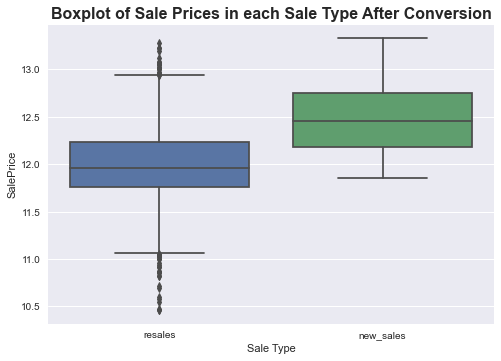

In [174]:
ax = sns.boxplot(x='Sale Type', y='SalePrice', data=X)
ax.set_title('Boxplot of Sale Prices in each Sale Type After Conversion', fontsize='16', fontweight='bold');

## Exploring Quantitative Features

Next, let's evaluate the quantitative features to see if they are:
1. distributed normally
2. show good correlation (relationship) with sale price
3. not correlated with each other

Before we proceed into more detailed analysis, we would like to convert 3 of our features to better reflect them as numerical features:<br>
**Year Built**: translate to house_age, which is the age of the house when sold. Calculated by taking Yr Sold - Year Built<br>
**Year Remod/Add**: translate to remod_age, which is how long since the house was last remod when sold. Calculated by taking Yr Sold - Year Remod/Add<br>
**Garage Yr Blt**: translate to garage_age, which is the age of garage when sold. Calculated by taking Yr Sold - Garage Yr Blt

In [175]:
X['house_age'] = X['Yr Sold'] - X['Year Built']
X['remod_age'] = X['Yr Sold'] - X['Year Remod/Add']
X['garage_age'] = X['Yr Sold'] - X['Garage Yr Blt']

In [176]:
# selecting only the pure numerical features
num_features = ['Lot Frontage', 'Lot Area', 'house_age', 'remod_age',
                'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 
                'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
                'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
                'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 
                'Fireplaces', 'garage_age', 'Garage Cars', 'Garage Area',
                'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 
                'Screen Porch', 'Pool Area', 'Misc Val',
               ]
X[num_features].describe().T

count          mean          std     min     25%     50%  \
Lot Frontage     2049.0     68.880429    21.318865    21.0    60.0    68.0   
Lot Area         2049.0  10063.202538  6745.034923  1300.0  7500.0  9405.0   
house_age        2049.0     36.032211    30.201616    -1.0     7.0    34.0   
remod_age        2049.0     23.561737    21.015996    -2.0     4.0    15.0   
Mas Vnr Area     2049.0     98.722792   174.382527     0.0     0.0     0.0   
BsmtFin SF 1     2049.0    442.516349   461.213114     0.0     0.0   368.0   
BsmtFin SF 2     2049.0     47.982430   165.037776     0.0     0.0     0.0   
Bsmt Unf SF      2049.0    567.674475   445.056730     0.0   220.0   474.0   
Total Bsmt SF    2049.0   1058.173255   449.441944     0.0   793.0   995.0   
1st Flr SF       2049.0   1164.860908   396.457593   334.0   880.0  1093.0   
2nd Flr SF       2049.0    329.650561   425.754353     0.0     0.0     0.0   
Low Qual Fin SF  2049.0      5.518302    51.093509     0.0     0.0     0.0   
Gr Liv Area      2049.0   1500.029771   500.187888   334.0  1131.0  1445.0   
Bsmt Full Bath   2049.0      0.427526     0.522673     0.0     0.0     0.0   
Bsmt Half Bath   2049.0      0.063446     0.251705     0.0     0.0     0.0   
Full Bath        2049.0      1.577843     0.549251     0.0     1.0     2.0   
Half Bath        2049.0      0.371401     0.501153     0.0     0.0     0.0   
Bedroom AbvGr    2049.0      2.844314     0.826601     0.0     2.0     3.0   
Kitchen AbvGr    2049.0      1.042948     0.209888     0.0     1.0     1.0   
TotRms AbvGrd    2049.0      6.437775     1.559734     2.0     5.0     6.0   
Fireplaces       2049.0      0.591020     0.638631     0.0     0.0     1.0   
garage_age       2049.0    139.118106   454.342728  -200.0     7.0    30.0   
Garage Cars      2049.0      1.775500     0.765698     0.0     1.0     2.0   
Garage Area      2049.0    473.284529   216.134217     0.0   319.0   480.0   
Wood Deck SF     2049.0     93.925329   128.578704     0.0     0.0     0.0   
Open Porch SF    2049.0     47.603221    66.763270     0.0     0.0    27.0   
Enclosed Porch   2049.0     22.593948    59.870165     0.0     0.0     0.0   
3Ssn Porch       2049.0      2.593948    25.241801     0.0     0.0     0.0   
Screen Porch     2049.0     16.527574    57.399890     0.0     0.0     0.0   
Pool Area        2049.0      2.400195    37.800940     0.0     0.0     0.0   
Misc Val         2049.0     51.624695   573.671628     0.0     0.0     0.0   

                     75%       max  
Lot Frontage        78.0     313.0  
Lot Area         11512.0  159000.0  
house_age           54.0     136.0  
remod_age           43.0      60.0  
Mas Vnr Area       160.0    1600.0  
BsmtFin SF 1       734.0    5644.0  
BsmtFin SF 2         0.0    1474.0  
Bsmt Unf SF        811.0    2336.0  
Total Bsmt SF     1319.0    6110.0  
1st Flr SF        1405.0    5095.0  
2nd Flr SF         694.0    1862.0  
Low Qual Fin SF      0.0    1064.0  
Gr Liv Area       1729.0    5642.0  
Bsmt Full Bath       1.0       3.0  
Bsmt Half Bath       0.0       2.0  
Full Bath            2.0       4.0  
Half Bath            1.0       2.0  
Bedroom AbvGr        3.0       8.0  
Kitchen AbvGr        1.0       3.0  
TotRms AbvGrd        7.0      15.0  
Fireplaces           1.0       4.0  
garage_age          50.0    2010.0  
Garage Cars          2.0       5.0  
Garage Area        576.0    1418.0  
Wood Deck SF       168.0    1424.0  
Open Porch SF       70.0     547.0  
Enclosed Porch       0.0     432.0  
3Ssn Porch           0.0     508.0  
Screen Porch         0.0     490.0  
Pool Area            0.0     800.0  
Misc Val             0.0   17000.0

We notice negative values in the minimum values for house_age, remod_age and garage_age, let's investigate these first before we proceed:

In [177]:
X.loc[(X['house_age'] < 0) | (X['remod_age'] < 0) | (X['garage_age'] < 0)]

Id        PID MS SubClass MS Zoning  Lot Frontage  Lot Area Lot Shape  \
1697  2261  916384070          20        RL          68.0      8298       Irr   
1717  1703  528120010          60        RL         134.0     16659       Irr   
1883  2181  908154195          20        RL         128.0     39290       Irr   

     Land Contour Lot Config Neighborhood Condition 1  Overall Qual  \
1697       Others     Inside       Timber        Norm             7   
1717          Lvl     Others      NridgHt        Norm             7   
1883       Others     Inside      Edwards        Norm             9   

      Year Built  Year Remod/Add Mas Vnr Type  Mas Vnr Area  Exter Qual  \
1697        2006            2007         None           0.0           4   
1717        2007            2008         None           0.0           4   
1883        2008            2009      Present        1224.0           5   

     Foundation  Bsmt Qual  Bsmt Exposure  BsmtFin Type 1  BsmtFin SF 1  \
1697      PConc          3              3               2         583.0   
1717      PConc          3              1               1           0.0   
1883      PConc          4              4               2        4010.0   

      BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  Heating QC  Central Air  \
1697           0.0        963.0         1546.0           5            1   
1717           0.0       1582.0         1582.0           5            1   
1883           0.0       1085.0         5095.0           5            1   

      Electrical  1st Flr SF  2nd Flr SF  Low Qual Fin SF  Gr Liv Area  \
1697           1        1564           0                0         1564   
1717           1        1582         570                0         2152   
1883           1        5095           0                0         5095   

      Bsmt Full Bath  Bsmt Half Bath  Full Bath  Half Bath  Bedroom AbvGr  \
1697             0.0             0.0          2          0              2   
1717             0.0             0.0          2          1              3   
1883             1.0             1.0          2          1              2   

      Kitchen AbvGr  Kitchen Qual  TotRms AbvGrd  Fireplaces  Fireplace Qu  \
1697              1             5              6           1             4   
1717              1             4              7           1             4   
1883              1             5             15           2             4   

      Garage Yr Blt  Garage Finish  Garage Cars  Garage Area  Paved Drive  \
1697         2207.0              2          2.0        502.0            1   
1717         2007.0              1          2.0        728.0            1   
1883         2008.0              3          3.0       1154.0            1   

      Wood Deck SF  Open Porch SF  Enclosed Porch  3Ssn Porch  Screen Porch  \
1697           132              0               0           0             0   
1717             0            368               0           0             0   
1883           546            484               0           0             0   

      Pool Area  Misc Val  Mo Sold  Yr Sold  Sale Type  SalePrice  house_age  \
1697          0         0        9     2007  new_sales  12.496127          1   
1717          0         0        6     2007  new_sales  12.468883          0   
1883          0     17000       10     2007  new_sales  12.121875         -1   

      remod_age  garage_age  
1697          0      -200.0  
1717         -1         0.0  
1883         -2        -1.0

For index 1697:  The Garage Yr Blt is inputed wrongly, we will set it to 2007 the year it was remod, and garage_age = 0. <br>
For index 1717 and 1883, since these are new sales and subsequently remod, we shall set  house_age, remod_age and garage_age = 0:

In [178]:
X.loc[1697, ['Garage Yr Blt', 'garage_age']] = [2007, 0]
X.loc[[1717, 1883], ['house_age', 'remod_age', 'garage_age']] = 0

In [179]:
# Check
X.loc[[1697, 1717, 1883], :]

Id        PID MS SubClass MS Zoning  Lot Frontage  Lot Area Lot Shape  \
1697  2261  916384070          20        RL          68.0      8298       Irr   
1717  1703  528120010          60        RL         134.0     16659       Irr   
1883  2181  908154195          20        RL         128.0     39290       Irr   

     Land Contour Lot Config Neighborhood Condition 1  Overall Qual  \
1697       Others     Inside       Timber        Norm             7   
1717          Lvl     Others      NridgHt        Norm             7   
1883       Others     Inside      Edwards        Norm             9   

      Year Built  Year Remod/Add Mas Vnr Type  Mas Vnr Area  Exter Qual  \
1697        2006            2007         None           0.0           4   
1717        2007            2008         None           0.0           4   
1883        2008            2009      Present        1224.0           5   

     Foundation  Bsmt Qual  Bsmt Exposure  BsmtFin Type 1  BsmtFin SF 1  \
1697      PConc          3              3               2         583.0   
1717      PConc          3              1               1           0.0   
1883      PConc          4              4               2        4010.0   

      BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  Heating QC  Central Air  \
1697           0.0        963.0         1546.0           5            1   
1717           0.0       1582.0         1582.0           5            1   
1883           0.0       1085.0         5095.0           5            1   

      Electrical  1st Flr SF  2nd Flr SF  Low Qual Fin SF  Gr Liv Area  \
1697           1        1564           0                0         1564   
1717           1        1582         570                0         2152   
1883           1        5095           0                0         5095   

      Bsmt Full Bath  Bsmt Half Bath  Full Bath  Half Bath  Bedroom AbvGr  \
1697             0.0             0.0          2          0              2   
1717             0.0             0.0          2          1              3   
1883             1.0             1.0          2          1              2   

      Kitchen AbvGr  Kitchen Qual  TotRms AbvGrd  Fireplaces  Fireplace Qu  \
1697              1             5              6           1             4   
1717              1             4              7           1             4   
1883              1             5             15           2             4   

      Garage Yr Blt  Garage Finish  Garage Cars  Garage Area  Paved Drive  \
1697         2007.0              2          2.0        502.0            1   
1717         2007.0              1          2.0        728.0            1   
1883         2008.0              3          3.0       1154.0            1   

      Wood Deck SF  Open Porch SF  Enclosed Porch  3Ssn Porch  Screen Porch  \
1697           132              0               0           0             0   
1717             0            368               0           0             0   
1883           546            484               0           0             0   

      Pool Area  Misc Val  Mo Sold  Yr Sold  Sale Type  SalePrice  house_age  \
1697          0         0        9     2007  new_sales  12.496127          1   
1717          0         0        6     2007  new_sales  12.468883          0   
1883          0     17000       10     2007  new_sales  12.121875          0   

      remod_age  garage_age  
1697          0         0.0  
1717          0         0.0  
1883          0         0.0

We would also like to check the houses that have 0 values for full bath, Bedroom AbvGr, and Kitchen AbvGr:

In [180]:
X.loc[(X['Full Bath']==0) |
      (X['Bedroom AbvGr']==0) | 
      (X['Kitchen AbvGr'] ==0)]

Id        PID MS SubClass MS Zoning  Lot Frontage  Lot Area Lot Shape  \
190   2119  906475170          20        RL         155.0     20064       Irr   
345   2724  905200490          80        RL          68.0     10246       Irr   
399    809  906226080          90        RL          64.0      7018       Reg   
743   1386  905200090          90        RL          60.0     12900       Reg   
1136  2821  908103320          90        RL          35.0      9400       Irr   
1279  1743  528228275          20        RL          53.0      3922       Reg   
1307  1000  527127140          20        RL          41.0      4923       Reg   
1371   766  904301375          30        RL          68.0     10020       Irr   
1517  2881  911175430          20    Others          50.0      9000       Reg   
1518  2820  908103310          90        RL          38.0      7840       Irr   
1570  2523  533350050          20        RL          68.0     50271       Irr   

     Land Contour Lot Config Neighborhood Condition 1  Overall Qual  \
190        Others     Inside       Sawyer        Norm             7   
345           Lvl     Others       Sawyer        Norm             3   
399        Others     Inside       Sawyer      Others             4   
743           Lvl     Inside       Sawyer      Others             3   
1136          Lvl     Others      Edwards        Norm             5   
1279          Lvl     Inside      Gilbert        Norm             6   
1307          Lvl     Inside      Gilbert        Norm             7   
1371       Others     Inside      Edwards        Norm             1   
1517          Lvl     Inside       IDOTRR        Norm             1   
1518          Lvl     Others      Edwards        Norm             5   
1570       Others     Inside      NoRidge        Norm             8   

      Year Built  Year Remod/Add Mas Vnr Type  Mas Vnr Area  Exter Qual  \
190         1976            1976         None           0.0           4   
345         1965            2001         None           0.0           3   
399         1979            1979      Present         275.0           3   
743         1969            1969         None           0.0           3   
1136        1975            1975      Present         250.0           3   
1279        2006            2007      Present          72.0           4   
1307        2001            2002         None           0.0           4   
1371        1922            1950         None           0.0           2   
1517        1949            1950         None           0.0           3   
1518        1975            1975      Present         355.0           3   
1570        1981            1987         None           0.0           4   

     Foundation  Bsmt Qual  Bsmt Exposure  BsmtFin Type 1  BsmtFin SF 1  \
190      CBlock          3              4               1          51.0   
345      CBlock          2              3               2         648.0   
399      CBlock          3              3               2        1086.0   
743      CBlock          3              3               2        1198.0   
1136     CBlock          3              4               2         945.0   
1279      PConc          4              3               1           0.0   
1307      PConc          4              3               2        1153.0   
1371     Others          1              4               1         350.0   
1517     CBlock          2              3               1          50.0   
1518     CBlock          3              4               2         976.0   
1570     CBlock          4              4               2        1810.0   

      BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  Heating QC  Central Air  \
190          915.0          0.0          966.0           5            1   
345            0.0          0.0          648.0           5            1   
399            0.0          0.0         1086.0           3            1   
743            0.0          0.0         1198.0           3            1   
1136 

Researching the meaning of Above Grade, it refers to above ground. Hence, for these houses, some of the noted 0 values for Above Grade probably mean that the Rooms or Baths are in the basement (ie, below grade). Hence, we leave these values as-is.<br>

Additionally, recall that when we were filling missing values, we had 113 houses without a garage and we initially fill the Garage Yr Blt for these houses to be 0. Translating that to garage_age would mean a very large garage_age for these houses, even though they do not have a garage. Lastly, for those houses with a garage, their garage_age would likely be highly correlated with house_age, hence we shall belatedly drop Garage Yr Blt and garage_age from our consideration:

In [181]:
X.drop(['Garage Yr Blt', 'garage_age'], axis=1, inplace=True)

Next, we look at the distributions and scatter plots for these numerical features:

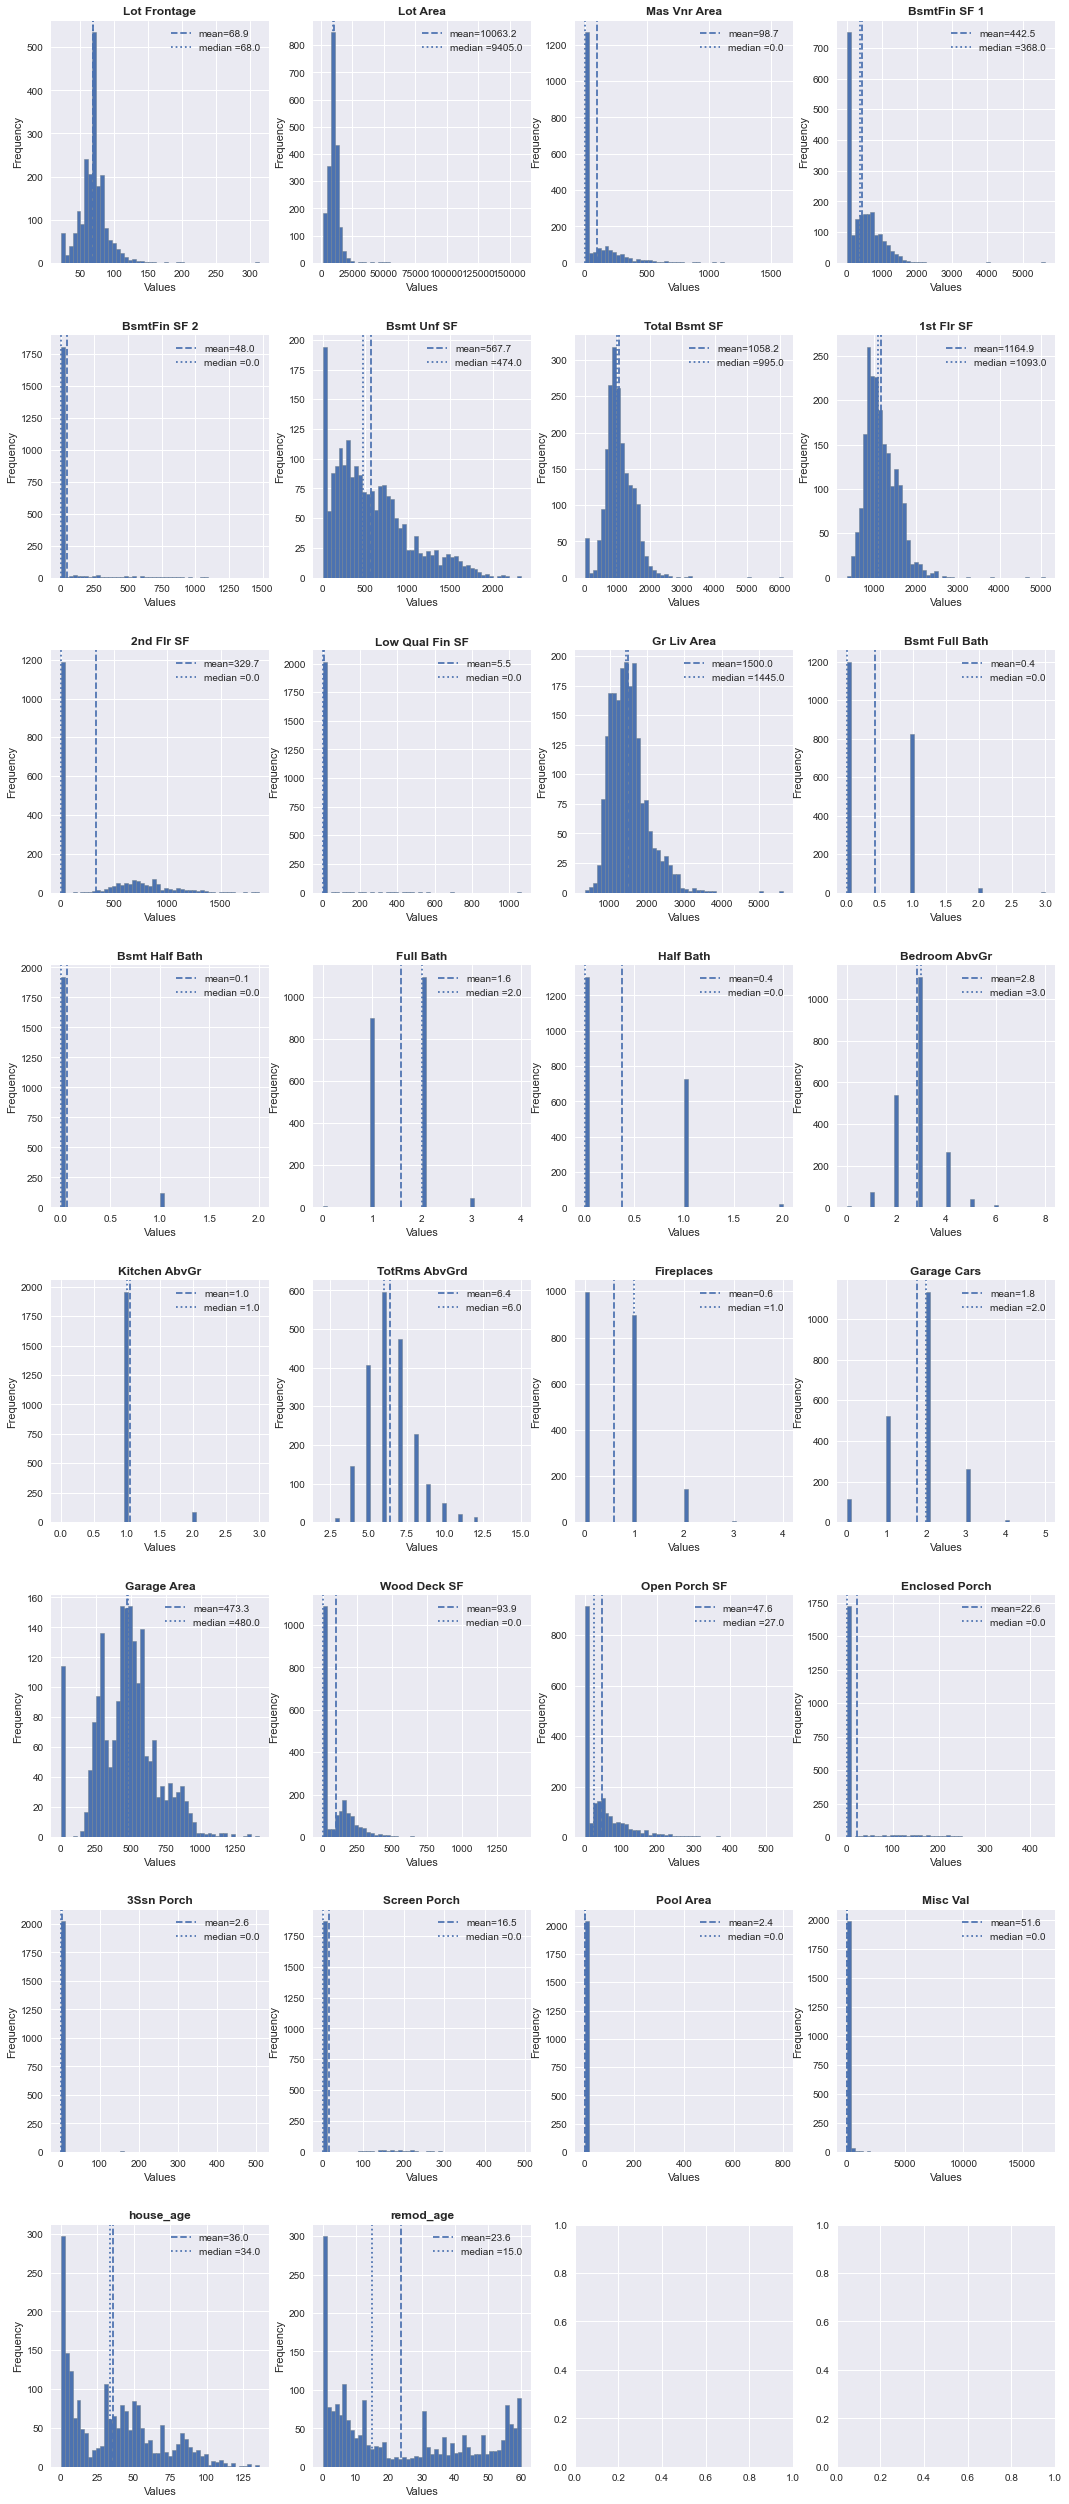

In [182]:
# update our numerical list removing garage_age:
num_features = ['Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 
                'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', 
                '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 
                'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 
                'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 
                'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', 
                '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 
                'house_age', 'remod_age'
               ]

num_rows = int(np.ceil(len(num_features)/4))
fig, ax = plt.subplots(nrows=num_rows, ncols=4, figsize =(18, 45))
plt.subplots_adjust(hspace=0.3, wspace=0.2)
ax = ax.ravel()
for i, column in enumerate(num_features):
    ax[i].hist(X[column], edgecolor='slategray', linewidth=0.5, bins=50)
    ax[i].axvline(X[column].mean(), label=f'mean={round(X[column].mean(),1)}', ls='--')
    ax[i].axvline(X[column].median(), label=f'median ={round(X[column].median(),1)}', ls=':')
    
    ax[i].set_title(column, fontsize=12, fontweight='bold')
    ax[i].legend()
    ax[i].set_xlabel('Values')
    ax[i].set_ylabel('Frequency')


plt.show()

We immediately notice that a number of the features have distributions that are not immediately useful, either because they have majority of the values in one portion, or the spread (variety) in the values are just not enough: 
1. Large number of 0: Mas Vnr Area, Bsmt SF 1, Bsmt SF 2, 2nd Flr SF, Low Qual Fin SF, Bsmt Half Bath, all the porches, Pool Area, Misc Val
2. Little spread in values: Lot Area, Kitchen Abv Gr 
<br>

Also, recall that we have inputted 330 missing values to be the median for Lot Frontage. <br>
Let's proceed to plot the scatter plots with respect to SalePrice:

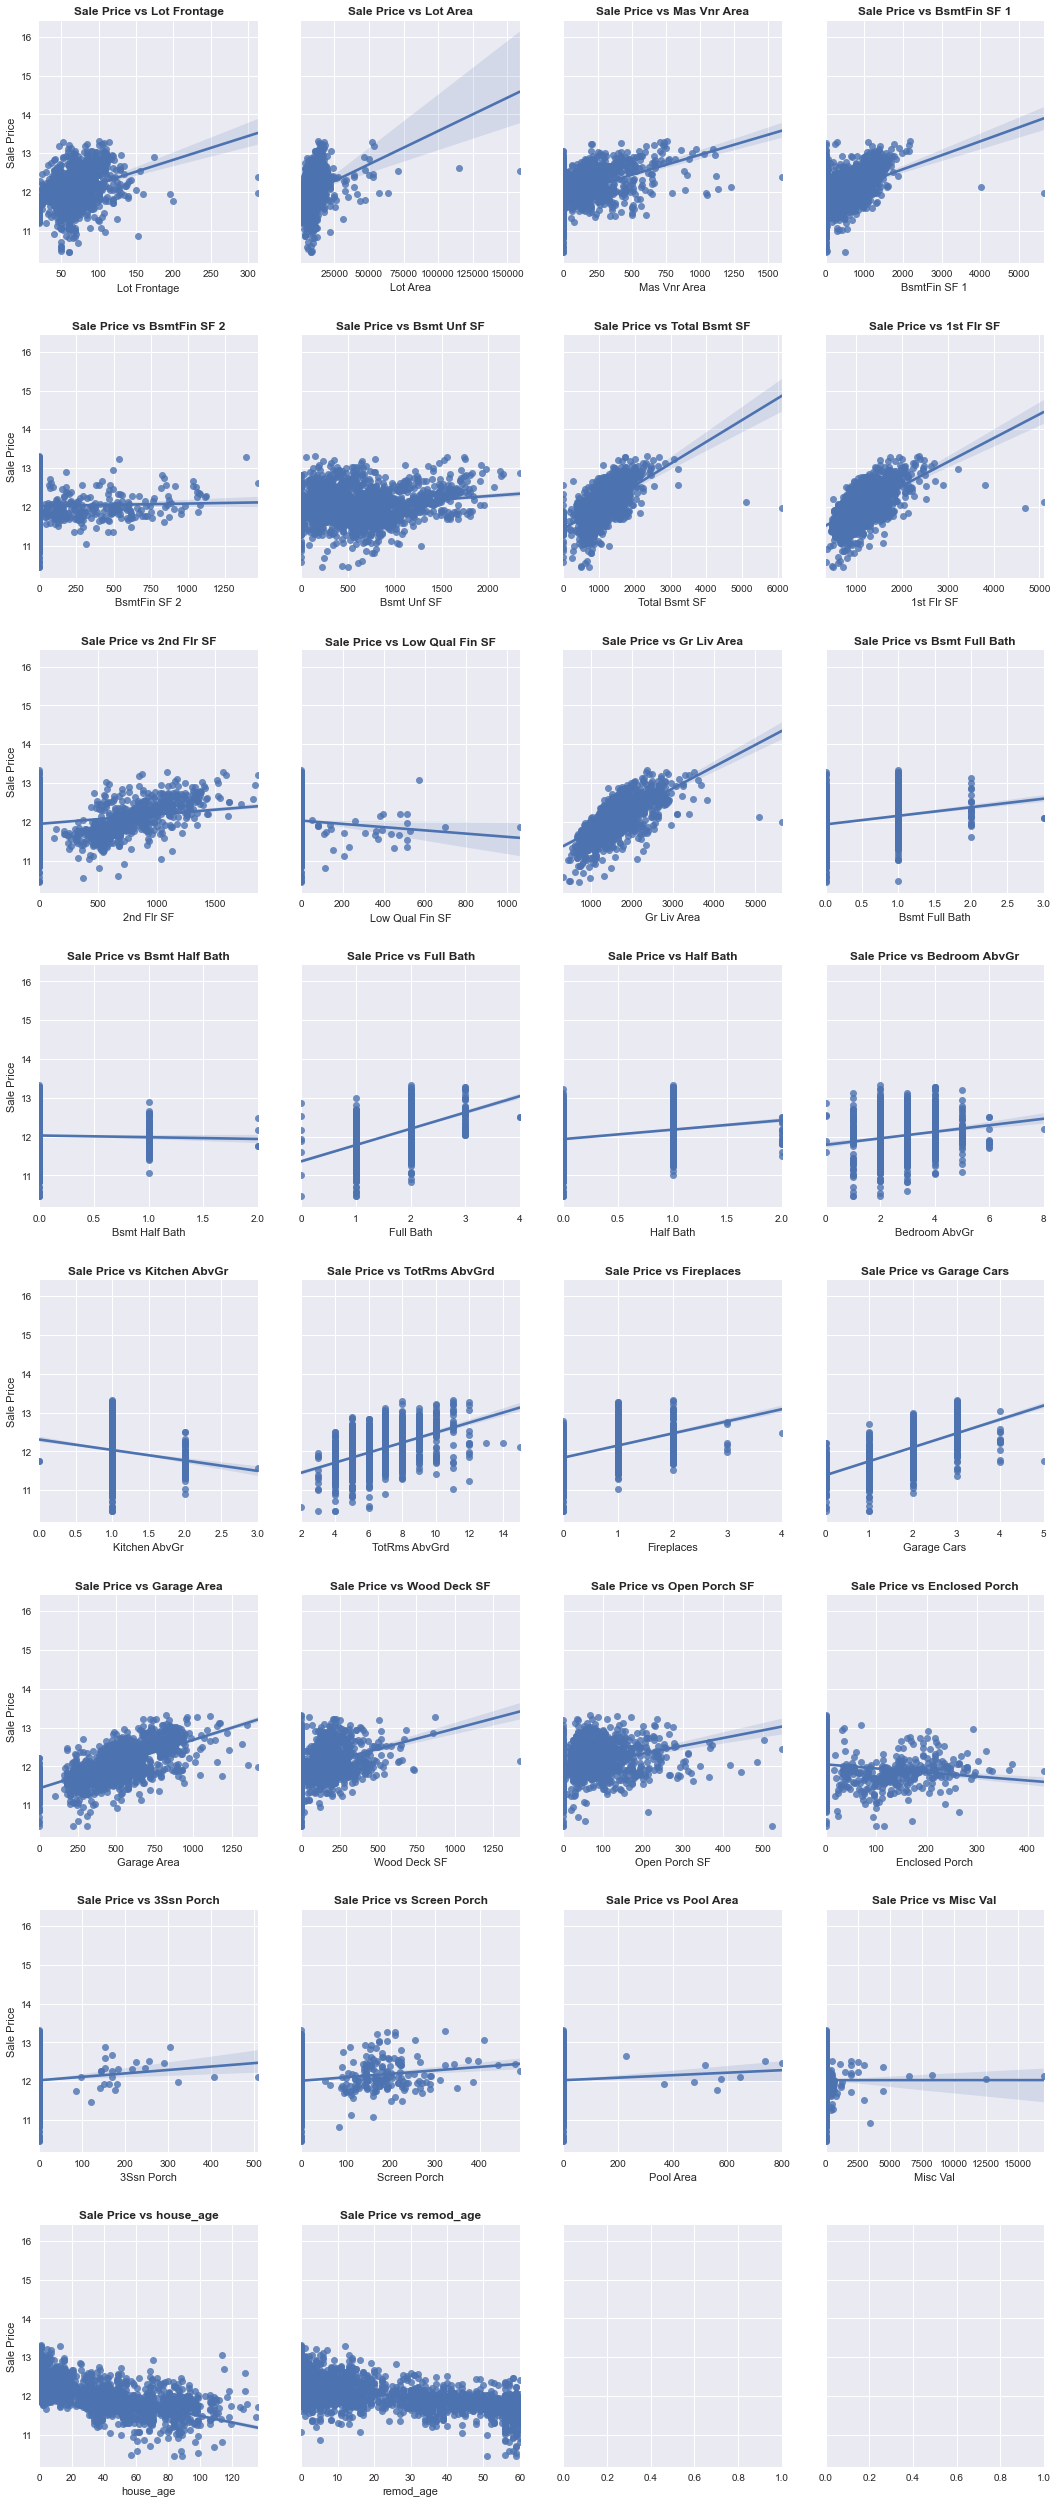

In [183]:
fig, ax = plt.subplots(nrows=num_rows, ncols=4, figsize =(18, 45), sharey=True)
plt.subplots_adjust(hspace=0.3, wspace=0.2)
ax = ax.ravel()
for i, column in enumerate(num_features):
    if i%4 ==0:
        sns.regplot(x=column, y='SalePrice', data=X, ax=ax[i])
        ax[i].set_ylabel('Sale Price')
    else:
        sns.regplot(x=column, y='SalePrice', data=X, ax=ax[i])
        ax[i].set_ylabel('')

    ax[i].set_title(f'Sale Price vs {column}', fontsize=12, fontweight='bold')
plt.show()

Some of our initial concerns with the distribution prove to be right. For eg, the regression line for Sale Price vs Lot Area is heavily impacted by the extreme outliers instead of showing a stronger correlation and while there seems to be a good correlation for Mas Vnr Area with Sale Price, we must remember that more than 1200 values have 0. <br>

We see a number of features that could possibly help to explain Sale Price. Most are expected, like Gr Liv Area, as the larger the area, the larger the house and hence high Sale Price. However, we believe a number of these features are correlated with each other.<br>

Let us proceed to look at the correlation heatmap and the pearson's correlation for these features with Sale Price:

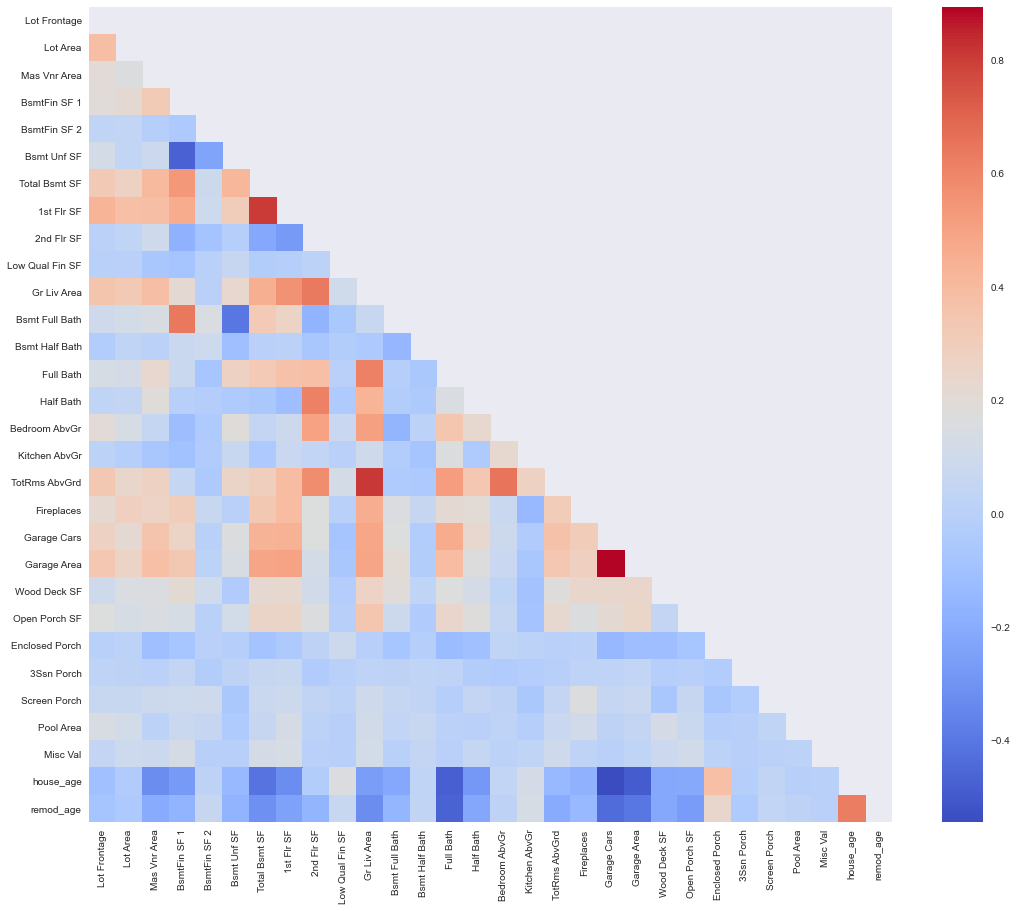

In [184]:
plt.figure(figsize=(18,15))
corr = X[num_features].corr()
mask=np.triu(corr)
sns.heatmap(X[num_features].corr(), mask=mask, cmap='coolwarm');

As expected, a number of the features are correlated with each other, especially if they describe similar things like:<br>
    - Garage Cars, Garage Area
    - house_age, remod_age
    - Gr Liv Area, TotRms AbvGrd, Full Bath, 1st Flr SF, 2nd Flr SF, Total Bsmt SF, Fireplaces, Mas Vnr Area

Furthermore, from our observations, for houses that typically have only a basement and 1 floor, the basement square feet is considered as the 1st floor square feet, so it might not make sense to include both Gr Liv Area (which is 1st Floor square feet + 2nd Floor square feet) together with total basement square feet.

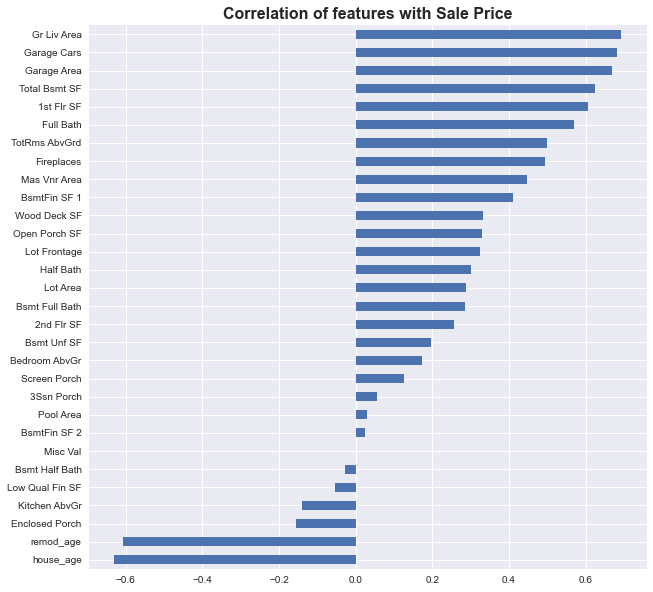

In [185]:
corr = X[num_features].corrwith(X['SalePrice']).sort_values(ascending=False)
plt.figure(figsize=(10,10))
ax = corr.sort_values(ascending=True).plot.barh()
ax.set_title('Correlation of features with Sale Price', fontsize=16, fontweight='bold');

Let us further create interaction features that might better help explain sale price:
1. Garage Cars x Garage Area: Since both are correlated with sale price. Also, There is perhaps little point in having a garage that can fit 0 cars <br>
2. Similarly, TotRms AbvGrd x Gr Liv Area <br>
3. Overall Qual x Gr Liv Area: Specifically, we are proposing that overall quality with a larger living area is worth much more than one that has either lower quality or living area and that they have synergy when considered together<br>

Looking at the scatterplot of these interaction terms with Sale Price below:

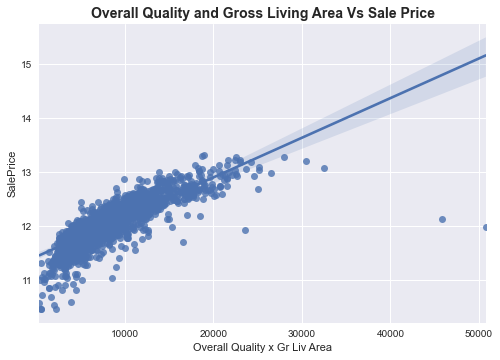

In [186]:
ax = sns.regplot(x=(X['Overall Qual']*X['Gr Liv Area']), y='SalePrice', data=X)
ax.set_title('Overall Quality and Gross Living Area Vs Sale Price', fontsize=14, fontweight='bold')
ax.set_xlabel('Overall Quality x Gr Liv Area')
plt.show()

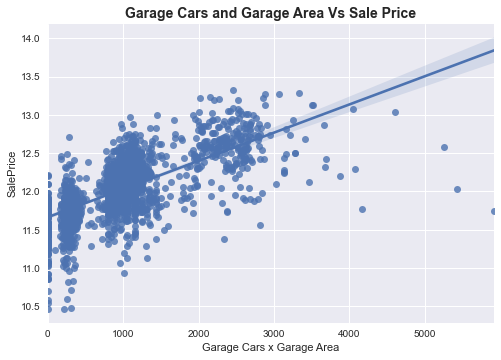

In [187]:
ax = sns.regplot(x=(X['Garage Cars']*X['Garage Area']), y='SalePrice', data=X)
ax.set_title('Garage Cars and Garage Area Vs Sale Price', fontsize=14, fontweight='bold')
ax.set_xlabel('Garage Cars x Garage Area')
plt.show()

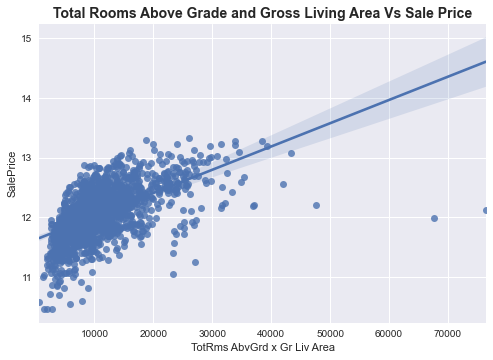

In [188]:
ax = sns.regplot(x=(X['TotRms AbvGrd']*X['Gr Liv Area']), y='SalePrice', data=X)
ax.set_title('Total Rooms Above Grade and Gross Living Area Vs Sale Price', fontsize=14, fontweight='bold')
ax.set_xlabel('TotRms AbvGrd x Gr Liv Area')
plt.show()

In [189]:
# Creating the interaction terms:
X['overall_qual_liv_area'] = X['Overall Qual'] * X['Gr Liv Area']
X['garage_cars_area'] = X['Garage Cars'] * X['Garage Area']
X['tot_rms_liv_area'] = X['TotRms AbvGrd'] * X['Gr Liv Area']

Our selection for the numercial features to include is completed. We include:
1. Gr Liv Area
2. house_age
3. Garage Area
4. overall_qual_liv_area
5. garage_cars_area
6. tot_rms_liv_area

## Feature Selection and Validation

In [190]:
selected_features = ['MS SubClass', 'MS Zoning', 'Lot Shape', 'Land Contour', 'Lot Config',
                     'Neighborhood', 'Condition 1', 'Overall Qual', 'Mas Vnr Type', 'Exter Qual',
                     'Foundation', 'Bsmt Qual', 'Bsmt Exposure', 'BsmtFin Type 1', 'Heating QC',
                     'Central Air', 'Electrical', 'Gr Liv Area', 'Kitchen Qual', 'Fireplace Qu',
                     'Garage Finish', 'Garage Area', 'Paved Drive', 'Sale Type', 'house_age',
                     'overall_qual_liv_area', 'garage_cars_area', 'tot_rms_liv_area']

# specifying our target
y = X['SalePrice']

# dropping the features that are not in our selected list
for feature in X.columns:
    if feature not in selected_features:
        X.drop(feature, axis=1, inplace=True)

In [191]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049 entries, 0 to 2048
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   MS SubClass            2049 non-null   object 
 1   MS Zoning              2049 non-null   object 
 2   Lot Shape              2049 non-null   object 
 3   Land Contour           2049 non-null   object 
 4   Lot Config             2049 non-null   object 
 5   Neighborhood           2049 non-null   object 
 6   Condition 1            2049 non-null   object 
 7   Overall Qual           2049 non-null   int64  
 8   Mas Vnr Type           2049 non-null   object 
 9   Exter Qual             2049 non-null   int64  
 10  Foundation             2049 non-null   object 
 11  Bsmt Qual              2049 non-null   int64  
 12  Bsmt Exposure          2049 non-null   int64  
 13  BsmtFin Type 1         2049 non-null   int64  
 14  Heating QC             2049 non-null   int64  
 15  Cent

In [192]:
# specify the features to create dummies:
dummies = ['MS SubClass', 'MS Zoning', 'Lot Shape', 'Land Contour', 'Lot Config', 
           'Neighborhood', 'Condition 1', 'Mas Vnr Type', 'Foundation', 'Sale Type']

# create dummy columns
X = pd.get_dummies(X, columns = dummies)

In [193]:
# for each type of dummy variable, specify the dummy to be dropped:
drop_dummies =  ['MS SubClass_70', 'MS Zoning_RM', 'Lot Shape_Irr', 'Land Contour_Others', 'Lot Config_Others',
                 'Neighborhood_Somerst', 'Condition 1_Norm', 'Mas Vnr Type_None', 'Foundation_PConc', 'Sale Type_new_sales']

# drop the selected dummies:
X.drop(drop_dummies, axis=1, inplace=True)

### Train / Validation Split and Cross Validation

With our selected features, let's see how well it performs in our various regression models. First let's create a validation set and scale our data accordingly:

In [194]:
# to avoid confusion with actual test set, we use 'valid', also setting test size to be 30%
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42, test_size = 0.3)

In [195]:
# Check
print(X_train.shape)
print(X_valid.shape)

(1434, 49)
(615, 49)


**Scaling**

In [196]:
# initialized and fit X_train
ss = StandardScaler()
ss.fit(X_train)

StandardScaler()

In [197]:
# scale data according to X_train
X_train_scaled = ss.transform(X_train)
X_valid_scaled = ss.transform(X_valid)

**Linear Regression Model**

The Linear Regression Model generates a line of best fit using ordinary least squares that minimizes the mean square error. The error is the difference between the actual values and the predicted values by the model. We square the difference because we do not want the negative differences to cancel out the positive differences. 

In [198]:
# initialized LR model
lr = LinearRegression()

In [199]:
# using 5 folds, we calculate the average R2 
lr_cv_scores = cross_val_score(lr, X_train_scaled, y_train, cv=5)
print(f'Average R2 score across 5 folds: {lr_cv_scores.mean()}')

Average R2 score across 5 folds: 0.8563060420916051


In [200]:
# likewise, we calculate the average mse for 5 folds
lr_cv_mse_scores = -cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
print(f'Average Mean Squared Error score across 5 folds: {lr_cv_mse_scores.mean()}')

Average Mean Squared Error score across 5 folds: 0.02432333849646136


In [201]:
# fit and predict the lr coefficients based on X_train and y_train
lr.fit(X_train_scaled, y_train)
lr_predict = lr.predict(X_valid_scaled)

In [202]:
# note that lr_predict and y is based on log price, we convert these back and compare the actual mse:
y_valid_convert = np.exp(y_valid)
lr_predict_convert = np.exp(lr_predict)

# calculated the mse on converted sale price
lr_mse_convert = mean_squared_error(y_valid_convert, lr_predict_convert)
print(f'Mean Squared Error of our validation set: {lr_mse_convert}')

Mean Squared Error of our validation set: 660768279.7679318


In [203]:
lr_rmse_convert = np.sqrt(lr_mse_convert)
print(f'Root Mean Squared Error of our validation set: {lr_rmse_convert}') 

Root Mean Squared Error of our validation set: 25705.413433125945


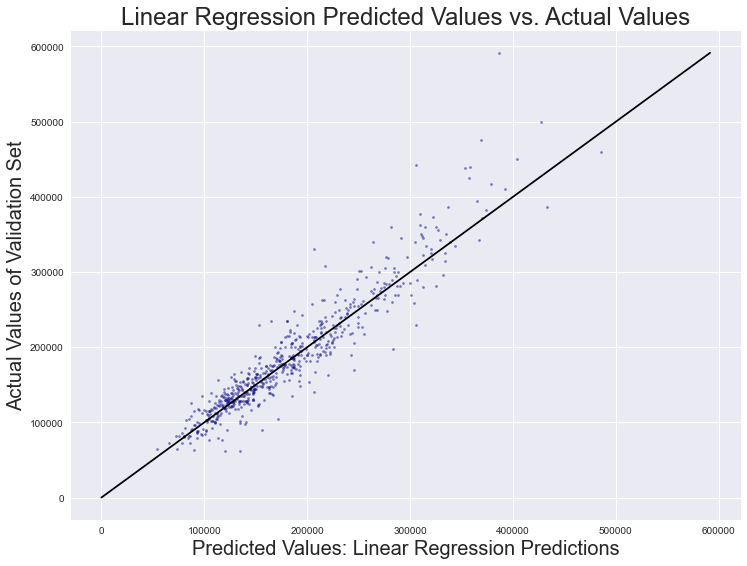

In [204]:
# Plot the predicted values vs the actual values for our validation set
plt.figure(figsize=(12,9))

# Generate a scatterplot of predicted values versus actual values.
plt.scatter(lr_predict_convert, y_valid_convert, s=5, color='darkblue', alpha = 0.5)

# Plot a line.
plt.plot([0, np.max(y_valid_convert)],
         [0, np.max(y_valid_convert)],
         color = 'black')

# Tweak title and axis labels.
plt.xlabel("Predicted Values: Linear Regression Predictions", fontsize = 20)
plt.ylabel("Actual Values of Validation Set", fontsize = 20)
plt.title('Linear Regression Predicted Values vs. Actual Values', fontsize = 24);

Comparing the predicted price by our basic linear regression model against the validation set, our root mean square error (rmse) score is 25705.413. Looking at the chart of predict values vs actual y values in the validation set, we see our model having good predictive value up till the $300,000 valuation. Thereafter, the model typically under-predict the actual values, generating higher rmse as a result. 


Using Ridge, Lasso and ElasticNet Regularization model later on, we are hoping that they will provide a lower rmse score:

**Ridge Regularization Model**

The Ridge Model is a type of L2 regularization model that regulates multiple regression data that suffers from multicollinearity. It seeks to regulate the coefficients by adding a penalty and thus reducing the likelihood that the model overfits the testing data and cannot be generalized for testing. 

In [205]:
# set to search alphas through logspace
ridge = RidgeCV(alphas=np.logspace(0, 20, 500)) 

In [206]:
# using 5 folds, we calculate the average R2 for Ridge model
ridge_cv_scores = cross_val_score(ridge, X_train_scaled, y_train, cv=5)
print(f'The Ridge average R2 score across 5 folds: {ridge_cv_scores.mean()}')

The Ridge average R2 score across 5 folds: 0.8545812677004461


In [207]:
# likewise, we calculate the average mse for 5 folds
ridge_cv_mse_scores = -cross_val_score(ridge, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
print(f'The Ridge average Mean Squared Error Score across 5 folds: {ridge_cv_mse_scores.mean()}')

The Ridge average Mean Squared Error Score across 5 folds: 0.02464855478963702


Our Ridge model seem to do slightly worse than our linear regression model as indicated by the cv scores for mse. We fit the train set to obtain the optimal alpha and generate the predictions to compare with our validation set:

In [208]:
ridge.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([1.00000000e+00, 1.09668060e+00, 1.20270833e+00, 1.31898690e+00,
       1.44650734e+00, 1.58635653e+00, 1.73972643e+00, 1.90792422e+00,
       2.09238348e+00, 2.29467637e+00, 2.51652705e+00, 2.75982639e+00,
       3.02664806e+00, 3.31926620e+00, 3.64017485e+00, 3.99210913e+00,
       4.37806863e+00, 4.80134292e+00, 5.26553963e+00, 5.77461515e+00,
       6.33290840e+00, 6.94517777e+0...
       1.19717134e+19, 1.31291459e+19, 1.43984795e+19, 1.57905331e+19,
       1.73171713e+19, 1.89914058e+19, 2.08275063e+19, 2.28411221e+19,
       2.50494154e+19, 2.74712079e+19, 3.01271407e+19, 3.30398507e+19,
       3.62341632e+19, 3.97373038e+19, 4.35791301e+19, 4.77923865e+19,
       5.24129830e+19, 5.74803016e+19, 6.30375315e+19, 6.91320378e+19,
       7.58157646e+19, 8.31456781e+19, 9.11842520e+19, 1.00000000e+20]))

In [209]:
# obtaining our ridge alpha
print(f'Ridge optimal alpha is {ridge.alpha_}')
ridge_alpha = ridge.alpha_

Ridge optimal alpha is 1.0


In [210]:
# Running ridge model again with the optimal alpha
ridge_opt = Ridge(alpha=ridge_alpha)
# fit it with our train data
ridge_opt.fit(X_train_scaled, y_train)
# generate predicted values for sale price
ridge_predict = ridge_opt.predict(X_valid_scaled)

In [211]:
# likewise, we need to convert the sale price back from the log price
ridge_predict_convert = np.exp(ridge_predict)

# calculated the mse on converted sale price
ridge_mse_convert = mean_squared_error(y_valid_convert, ridge_predict_convert)
print(f'The Mean Squared Error of Ridge on validation set: {ridge_mse_convert}')

The Mean Squared Error of Ridge on validation set: 658163647.8159097


In [212]:
ridge_rmse_convert = np.sqrt(ridge_mse_convert)
print(f'The Root Mean Squared Error of Ridge on validation set: {ridge_rmse_convert}') 

The Root Mean Squared Error of Ridge on validation set: 25654.700306491784


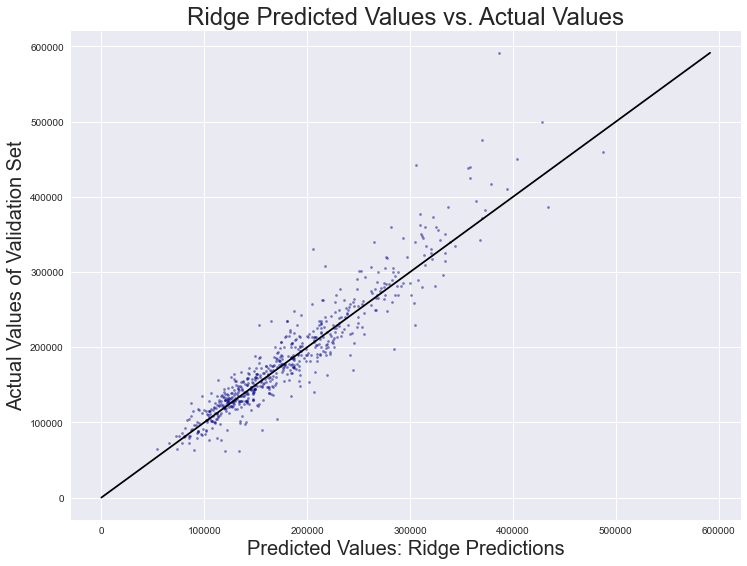

In [213]:
# Plot the predicted values vs the actual values for our validation set
plt.figure(figsize=(12,9))

# Generate a scatterplot of predicted values versus actual values.
plt.scatter(ridge_predict_convert, y_valid_convert, s=5, color='darkblue', alpha = 0.5)

# Plot a line.
plt.plot([0, np.max(y_valid_convert)],
         [0, np.max(y_valid_convert)],
         color = 'black')

# Tweak title and axis labels.
plt.xlabel("Predicted Values: Ridge Predictions", fontsize = 20)
plt.ylabel("Actual Values of Validation Set", fontsize = 20)
plt.title('Ridge Predicted Values vs. Actual Values', fontsize = 24);

Surprisingly, when predicting on our validation set, our ridge model rmse score has done slightly better than our linear regression score (note: higher is worse). <br>

Comparing the predicted price by our ridge model against the validation set, our root mean square error (rmse) score is 25654.7. Similarly, we see our model having good predictive value up till the $300,000 valuation. Thereafter, the model typically under-predict the actual values, generating higher rmse as a result, especially after the 350,000 valuation mark.


Let's look at Lasso next:

**Lasso Regularization Model**

Lasso or (Least absolute shrinkage and selection operator) is a L1 regularization model that is similar to Ridge regression in that they both seek to regulate the coefficient of the linear regression model by introducing a penalty term to make the model less overfit to the training data. The difference in Lasso is that Lasso can force certain coefficients to be 0 thereby making the model more interpretable:

In [214]:
#initialized Lasso CV model
lasso = LassoCV(n_alphas = 100)

In [215]:
# average R2 scores for lasso using 5 folds
lasso_cv_scores = cross_val_score(lasso, X_train_scaled, y_train, cv=5)
print(f'The Lasso average R2 score across 5 folds: {lasso_cv_scores.mean()}')

The Lasso average R2 score across 5 folds: 0.854708109265782


In [216]:
# average mse scores for lasso using 5 folds
lasso_cv_mse_scores = -cross_val_score(lasso, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

print(f'The Lasso average Mean Squared Error score across 5 folds: {lasso_cv_mse_scores.mean()}') 
# mse is higher than ridge for cross-val-score

The Lasso average Mean Squared Error score across 5 folds: 0.02463925672331979


From the cross validation, our Lasso model does better than the ridge but worse than linear regression in terms of the average mse scores. Next, we fit the train set to obtain the optimal alpha and generate the predictions to compare with our validation set:

In [217]:
lasso.fit(X_train_scaled, y_train)

LassoCV()

In [218]:
# obtaining our lasso alpha
print(f'The Lasso optimal Alpha is {lasso.alpha_}')
lasso_alpha = lasso.alpha_

The Lasso optimal Alpha is 0.0012599935167833844


In [219]:
# Running lasso model again with the optimal alpha
lasso_opt = Lasso(alpha=lasso_alpha)
# fit it with our train data
lasso_opt.fit(X_train_scaled, y_train)
# generate predicted values for sale price
lasso_predict = lasso_opt.predict(X_valid_scaled)

In [220]:
# convert the sale price back from the log price
lasso_predict_convert = np.exp(lasso_predict)

# calculated the mse on converted sale price
lasso_mse_convert = mean_squared_error(y_valid_convert, lasso_predict_convert)
print(f'The Lasso Mean Squared Error on validation set is {lasso_mse_convert}')

The Lasso Mean Squared Error on validation set is 636023715.6703248


In [221]:
lasso_rmse_convert = np.sqrt(lasso_mse_convert)
print(f'The Lasso Root Mean Squared Error on validation set is {lasso_rmse_convert}') 

The Lasso Root Mean Squared Error on validation set is 25219.510615202762


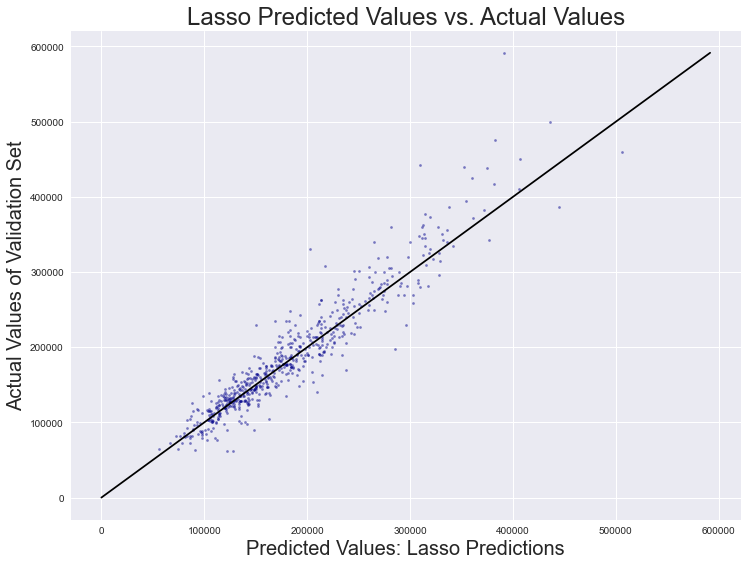

In [222]:
# Plot the predicted values vs the actual values for our validation set
plt.figure(figsize=(12,9))

# Generate a scatterplot of predicted values versus actual values.
plt.scatter(lasso_predict_convert, y_valid_convert, s=5, color='darkblue', alpha = 0.5)

# Plot a line.
plt.plot([0, np.max(y_valid_convert)],
         [0, np.max(y_valid_convert)],
         color = 'black')

# Tweak title and axis labels.
plt.xlabel("Predicted Values: Lasso Predictions", fontsize = 20)
plt.ylabel("Actual Values of Validation Set", fontsize = 20)
plt.title('Lasso Predicted Values vs. Actual Values', fontsize = 24);

We achieve our best rmse score of 25,219.51 so far with lasso. <br>

Likewise, we see our model having good predictive value up till the $300,000 valuation and perhaps a slight improvement in predictions around that mark. Thereafter, the model again under-predicts the actual values, generating higher rmse as a result, especially after the 350,000 valuation mark.


**ElasticNet Model**

ElasticNet model combines both the Ridge (L2) and Lasso (L1) regulation into the model and selects a ratio on that puts a weight on which model has more impact:

In [223]:
# set the range to search for the enet_ratio 
# let enet to automatically search for optimal alpha
enet_ratio = np.arange(0.01, 1.0, 0.005)  
enet = ElasticNetCV(l1_ratio=enet_ratio, cv=5)

In [224]:
# average R2 scores over 5 folds
enet_cv_score = cross_val_score(enet, X_train_scaled, y_train, cv=5)
print(f'The Enet average R2 score across 5 folds: {enet_cv_score.mean()}')

The Enet average R2 score across 5 folds: 0.8548346378431688


In [225]:
# average mse scores over 5 folds
enet_cv_mse_scores = -cross_val_score(enet, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
print(f'The Enet average Mean Squared Error score across 5 folds: {enet_cv_mse_scores.mean()}')

The Enet average Mean Squared Error score across 5 folds: 0.024618336808133294


From the cross validation, our Enet model does better compared to the rest in terms of the average mse scores. Next, we fit the train set to obtain the optimal alpha and l1_ratio and generate the predictions to compare with our validation set:

In [226]:
enet.fit(X_train_scaled, y_train)

ElasticNetCV(cv=5,
             l1_ratio=array([0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045, 0.05 ,
       0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 , 0.095,
       0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135, 0.14 ,
       0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 , 0.185,
       0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 , 0.225, 0.23 ,
       0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265, 0.27 , 0.275,
       0.28 , 0.285, 0.29 , 0.295...
       0.64 , 0.645, 0.65 , 0.655, 0.66 , 0.665, 0.67 , 0.675, 0.68 ,
       0.685, 0.69 , 0.695, 0.7  , 0.705, 0.71 , 0.715, 0.72 , 0.725,
       0.73 , 0.735, 0.74 , 0.745, 0.75 , 0.755, 0.76 , 0.765, 0.77 ,
       0.775, 0.78 , 0.785, 0.79 , 0.795, 0.8  , 0.805, 0.81 , 0.815,
       0.82 , 0.825, 0.83 , 0.835, 0.84 , 0.845, 0.85 , 0.855, 0.86 ,
       0.865, 0.87 , 0.875, 0.88 , 0.885, 0.89 , 0.895, 0.9  , 0.905,
       0.91 , 0.915, 0.92 , 0.925, 0.93 , 0.935, 0.94 , 0.945, 0.95 ,
       0.955

In [227]:
print(f'The Enet Alpha is {enet.alpha_}')
enet_alpha = enet.alpha_

print(f'The Enet L1_ratio is {enet.l1_ratio_}')
enet_ratio = enet.l1_ratio_  # enet l1_ratio is lower than 0.5 -> more lasso weighted

The Enet Alpha is 0.004007919953169125
The Enet L1_ratio is 0.25499999999999995


In [228]:
# running enet with the optimal alpha and l1_ratio
enet_opt = ElasticNet(alpha=enet_alpha, l1_ratio = enet_ratio)

In [229]:
# fit to our train data
enet_opt.fit(X_train_scaled, y_train)

ElasticNet(alpha=0.004007919953169125, l1_ratio=0.25499999999999995)

In [230]:
# generate predicted values
enet_predict = enet_opt.predict(X_valid_scaled)

In [231]:
# convert the sale price back from the log price
enet_predict_convert = np.exp(enet_predict)

# calculated the mse on converted sale price
enet_mse_convert = mean_squared_error(y_valid_convert, enet_predict_convert)
print(f'The Enet Mean Squared Error on validation set: {enet_mse_convert}')

The Enet Mean Squared Error on validation set: 636433881.1335219


In [232]:
enet_rmse_convert = np.sqrt(enet_mse_convert)
print(f'The Enet Root Mean Squared Error on validation set: {enet_rmse_convert}') 

The Enet Root Mean Squared Error on validation set: 25227.641212240233


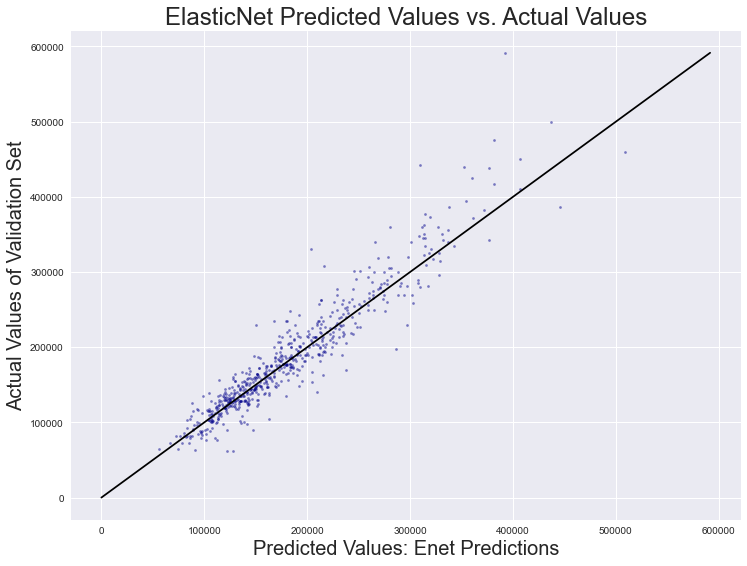

In [233]:
# Plot the predicted values vs the actual values for our validation set
plt.figure(figsize=(12,9))

# Generate a scatterplot of predicted values versus actual values.
plt.scatter(enet_predict_convert, y_valid_convert, s=5, color='darkblue', alpha = 0.5)

# Plot a line.
plt.plot([0, np.max(y_valid_convert)],
         [0, np.max(y_valid_convert)],
         color = 'black')

# Tweak title and axis labels.
plt.xlabel("Predicted Values: Enet Predictions", fontsize = 20)
plt.ylabel("Actual Values of Validation Set", fontsize = 20)
plt.title('ElasticNet Predicted Values vs. Actual Values', fontsize = 24);

Our ElasticNet rmse score on the validation set is actually very similar to the Lasso model score, albeit higher by about 8 points at 25,227.64. Due to the RMSE being so close, the predicted values are largely similar to Lasso's, with good predictability up till the $300,000 mark. Similarly, the model under-predicts the actual house price thereafter. 





Let's compare the coefficients generated by linear regression, ridge, lasso and elastic net:

In [234]:
# creating DataFrame for each model 
lr_coef = pd.DataFrame({'features': X.columns, 'lr_coef': lr.coef_})
ridge_coef = pd.DataFrame({'features': X.columns, 'ridge_coef': ridge_opt.coef_})
lasso_coef = pd.DataFrame({'features': X.columns, 'lasso_coef': lasso_opt.coef_})
enet_coef = pd.DataFrame({'features': X.columns, 'enet_coef': enet_opt.coef_})

# merging the dataframes
df_coef = pd.merge(lr_coef, ridge_coef, on=['features'])
df_coef = pd.merge(df_coef, lasso_coef, on=['features'])
df_coef = pd.merge(df_coef, enet_coef, on=['features'])

In [235]:
df_coef.sort_values(by='lasso_coef', ascending=False)

features   lr_coef  ridge_coef  lasso_coef  enet_coef
8             Gr Liv Area  0.274407    0.267913    0.214230   0.206060
0            Overall Qual  0.164971    0.160963    0.131454   0.126838
18         MS SubClass_20  0.061724    0.060937    0.042666   0.043702
16       garage_cars_area  0.042273    0.041815    0.038726   0.037883
9            Kitchen Qual  0.037868    0.037918    0.037526   0.037693
26           MS Zoning_RL  0.036273    0.036290    0.035112   0.035302
3           Bsmt Exposure  0.029116    0.029016    0.028706   0.028476
10           Fireplace Qu  0.023612    0.024004    0.026796   0.027400
4          BsmtFin Type 1  0.024443    0.024418    0.023695   0.023751
5              Heating QC  0.020279    0.020396    0.021030   0.021306
13            Paved Drive  0.021804    0.021786    0.020494   0.020422
31   Neighborhood_Crawfor  0.015811    0.015833    0.017683   0.018297
6             Central Air  0.016031    0.016261    0.017474   0.017762
24           MS Zoning_FV  0.016968    0.016975    0.017414   0.017835
39   Neighborhood_NridgHt  0.017098    0.016888    0.017342   0.017244
2               Bsmt Qual  0.019059    0.019033    0.017097   0.017449
21         MS SubClass_60  0.031545    0.030984    0.014287   0.015740
23         MS SubClass_90  0.018075    0.018046    0.010325   0.011567
38   Neighborhood_NoRidge  0.009832    0.009716    0.009944   0.010132
1              Exter Qual  0.013379    0.013191    0.009521   0.009831
7              Electrical  0.010352    0.010389    0.009297   0.009564
11          Garage Finish  0.009188    0.009306    0.009247   0.009433
20         MS SubClass_50  0.015502    0.015341    0.008325   0.009337
22         MS SubClass_80  0.018203    0.017829    0.007492   0.008271
44   Condition 1_Positive  0.004947    0.004995    0.004318   0.004604
12            Garage Area -0.001567   -0.001031    0.002270   0.003325
40   Neighborhood_OldTown  0.000009   -0.000216    0.000571   0.001192
45   Mas Vnr Type_Present -0.001183   -0.001164   -0.000000  -0.000000
46      Foundation_CBlock  0.001182    0.000927    0.000000  -0.000000
34    Neighborhood_IDOTRR -0.001618   -0.001709   -0.000000  -0.000000
42    Neighborhood_Timber -0.002712   -0.002654    0.000000   0.000000
41    Neighborhood_Sawyer -0.005031   -0.005063    0.000000   0.000000
36     Neighborhood_NAmes -0.005851   -0.005963   -0.000000  -0.000000
14              house_age  0.009318    0.009217    0.000000   0.000000
28       Land Contour_Lvl -0.002308   -0.002217   -0.000233  -0.000419
35   Neighborhood_Mitchel -0.003448   -0.003599   -0.000265  -0.000651
33   Neighborhood_Gilbert -0.007979   -0.007983   -0.001936  -0.002310
19         MS SubClass_30  0.006246    0.005494   -0.002215  -0.002753
29      Lot Config_Inside -0.004236   -0.004230   -0.003232  -0.003488
47      Foundation_Others -0.005084   -0.005113   -0.003367  -0.003319
37    Neighborhood_NWAmes -0.007491   -0.007434   -0.003608  -0.003521
30   Neighborhood_CollgCr -0.010559   -0.010588   -0.004774  -0.005202
27          Lot Shape_Reg -0.005030   -0.005119   -0.005480  -0.005642
48      Sale Type_resales -0.011235   -0.011028   -0.007955  -0.007926
43     Condition 1_Others -0.017104   -0.017058   -0.015373  -0.015557
32   Neighborhood_Edwards -0.024534   -0.024672   -0.020833  -0.021029
25       MS Zoning_Others -0.022037   -0.022079   -0.021666  -0.021721
17       tot_rms_liv_area -0.042662   -0.042020   -0.031523  -0.030253
15  overall_qual_liv_area -0.166439   -0.158139   -0.090425  -0.082121

Looking at the various coefficients from the 4 models, we see the Ridge, Lasso and Enet mostly reduced the coefficients in absolute terms, which is what we expect from regularization models so that our selected features do not overfit the training dataset. <br>

As we expected, quality (Overall Qual) and size (Gr Liv Area) were key determinants that helped to explain sale price, evidenced by their high coeficients, which were several times higher compared to some of the other features. Note that we are looking at the coefficients through the lens of log sale price. Converting back to normal sale price, the impact of Overall Qual and Gr Liv Area will be exponentially higher compared to the other features.

Lasso, (as well as Enet), being a L1 regularization model, reduces some of the coefficients to 0. These includes:
1. House age
2. Neighborhood_IDOTRR
3. Neighborhood_NAmes
4. Neighborhood_Sawyer
5. Mas Vnr Type_Present
6. Foundation_CBlock

What this essentially means is that Lasso ascertain that they do not provide information that can better explain Sale Price. In the case of House age, perhaps we have already distinguished between new sales and resales as one of our features (furthermore we dropped new sales dummy feature such that it is absorbed into our regression constant term), with positive house age values, it is already explained by the Sale Type_resales dummy feature. 

Similarly, for point 2-6 for the neighborhoods, these neighborhoods were predicted to be no different from our baseline, which is Neighborhood_somerst, the neighborhood we have dropped and was absorbed into the constant. 

Likewise, the same explanation for Foundation_CBlock which was predicted by Lasso to be no different in explaining sale price compared to the dummy that was dropped - Foundation_PConc.

For Mas Vnr Type, we have probably overfitted our features, and Lasso regulated this out, in effect predicting that Mas Vnr Type does not help to explain Sale Price in our model. 

Since Lasso simplified our model by removing 6 of our features and has the best rmse score, we will select Lasso as our final model.

## Optimal Model Selection and Testing

With Lasso as our selection model to run on test data, we will run a final lasso regression on our complete train data to optimize our final parameters to run on the test set. 

But first, let us prep our test dataset:

In [236]:
#load our prediction data
test = pd.read_csv('../datasets/test.csv')

In [237]:
# checking null values in the original test set:
test.isnull().sum()

Id                   0
PID                  0
MS SubClass          0
MS Zoning            0
Lot Frontage       160
Lot Area             0
Street               0
Alley              821
Lot Shape            0
Land Contour         0
Utilities            0
Lot Config           0
Land Slope           0
Neighborhood         0
Condition 1          0
Condition 2          0
Bldg Type            0
House Style          0
Overall Qual         0
Overall Cond         0
Year Built           0
Year Remod/Add       0
Roof Style           0
Roof Matl            0
Exterior 1st         0
Exterior 2nd         0
Mas Vnr Type         1
Mas Vnr Area         1
Exter Qual           0
Exter Cond           0
Foundation           0
Bsmt Qual           25
Bsmt Cond           25
Bsmt Exposure       25
BsmtFin Type 1      25
BsmtFin SF 1         0
BsmtFin Type 2      25
BsmtFin SF 2         0
Bsmt Unf SF          0
Total Bsmt SF        0
Heating              0
Heating QC           0
Central Air          0
Electrical 

In [238]:
# creating a test set from the test data:
test_set = test.copy()

In [239]:
# 879 entries, 80 columns, without sale price
test_set.shape

(879, 80)

We first remove the features that we are not considering in our model and then clean the data for missing values. <br>
Lastly, we convert the test data according to what we have done for the training set:

In [240]:
# removing unnecessary columns
for feature in test_set.columns:
    if feature not in selected_features:
        test_set.drop(feature, axis=1, inplace=True)

In [241]:
test_set.isnull().sum()

MS SubClass         0
MS Zoning           0
Lot Shape           0
Land Contour        0
Lot Config          0
Neighborhood        0
Condition 1         0
Overall Qual        0
Mas Vnr Type        1
Exter Qual          0
Foundation          0
Bsmt Qual          25
Bsmt Exposure      25
BsmtFin Type 1     25
Heating QC          0
Central Air         0
Electrical          1
Gr Liv Area         0
Kitchen Qual        0
Fireplace Qu      422
Garage Finish      45
Garage Area         0
Paved Drive         0
Sale Type           0
dtype: int64

In [242]:
missing_val_features = ['Mas Vnr Type', 'Bsmt Qual', 'Bsmt Exposure', 
                        'BsmtFin Type 1', 'Fireplace Qu', 'Garage Finish']

In [243]:
for feature in missing_val_features:
    test_set[feature].fillna('NA', inplace=True)

In [244]:
# locating the null value for electrical
test_set.loc[test_set['Electrical'].isnull()]

MS SubClass MS Zoning Lot Shape Land Contour Lot Config Neighborhood  \
635           80        RL       Reg          Lvl     Inside       Timber   

    Condition 1  Overall Qual Mas Vnr Type Exter Qual Foundation Bsmt Qual  \
635        Norm             5         None         TA      PConc        Gd   

    Bsmt Exposure BsmtFin Type 1 Heating QC Central Air Electrical  \
635            No            Unf         Gd           Y        NaN   

     Gr Liv Area Kitchen Qual Fireplace Qu Garage Finish  Garage Area  \
635         1394           Gd           NA           Fin          400   

    Paved Drive Sale Type  
635           Y       WD

We hypothesize that the type of electrical unit is related to the neighborhood that they are in:

In [245]:
test.loc[test['Neighborhood'] == 'Timber']

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
44   2256  916226090          120        RL          46.0      4054   Pave   
89   2895  916326010           20        RL           NaN     16669   Pave   
214   957  916176125           20        RL         150.0    215245   Pave   
245   322  921128020           20        RL          89.0     13214   Pave   
255   963  916403010           20        RL         130.0     11457   Pave   
260  2259  916326090           20        RL         149.0     19958   Pave   
299  1584  916455120           20        RL          82.0     11202   Pave   
307  1571  916125425          190        RL           NaN    164660   Grvl   
367  2274  917425190           20        RL          50.0     35133   Grvl   
369   967  916460110           60        RL          75.0      9157   Pave   
376  2275  921126010           20        RL          93.0     15306   Pave   
418  2898  916403130           60        RL           NaN     11170   Pave   
595   968  916475040           20        RL          85.0     14601   Pave   
635  1578  916386080           80        RL          73.0      9735   Pave   
641   958  916380070           20        RL          89.0     12898   Pave   
644  2263  916384150           20        RL          89.0     10991   Pave   
697   959  916382010           60        RL          83.0     13159   Pave   
717  2892  916225130           60        RL          42.0     26178   Pave   
750  2902  921205030           20        RL          88.0     11443   Pave   
766  2901  916477010           20        RL          95.0     13618   Pave   
769  1586  916477020           60        RL          85.0     12244   Pave   
777  1579  916386180           60        RL          81.0     12018   Pave   
826  2266  916403290           50        RL          44.0     13758   Pave   
867  2271  916460020           20        RL           NaN      7777   Pave   

    Alley Lot Shape Land Contour Utilities Lot Config Land Slope Neighborhood  \
44    NaN       IR1          Lvl    AllPub     Inside        Gtl       Timber   
89    NaN       IR1          Lvl    AllPub     Corner        Gtl       Timber   
214   NaN       IR3          Low    AllPub     Inside        Sev       Timber   
245   NaN       IR1          HLS    AllPub     Inside        Gtl       Timber   
255   NaN       IR1          Lvl    AllPub     Corner        Gtl       Timber   
260   NaN       Reg          Lvl    AllPub     Inside        Gtl       Timber   
299   NaN       IR1          Lvl    AllPub     Inside        Gtl       Timber   
307   NaN       IR1          HLS    AllPub     Corner        Sev       Timber   
367   NaN       Reg          Lvl    AllPub     Inside        Mod       Timber   
369   NaN       IR1          Lvl    AllPub     Corner        Gtl       Timber   
376   NaN       IR1          HLS    AllPub     Corner        Gtl       Timber   
418   NaN       IR2          Lvl    AllPub     Corner        Gtl       Timber   
595   NaN       Reg          Lvl    AllPub     Inside        Gtl       Timber   
635   NaN       Reg          Lvl    AllPub     Inside        Gtl       Timber   
641   NaN       IR1          HLS    AllPub     Inside        Gtl       Timber   
644   NaN       IR1          HLS    AllPub     Inside        Gtl       Timber   
697   NaN       IR1          HLS    AllPub     Corner        Gtl       Timber   
717   NaN       IR1          Lvl    AllPub     Inside        Mod       Timber   
750   NaN       Reg          Lvl    AllPub     Inside        Gtl       Timber   
766   NaN       Reg          Lvl    AllPub     Corner        Gtl       Timber   
769   NaN       Reg          Lvl    AllPub     Inside        Gtl       Timber   
777   NaN       IR1          HLS    AllPub     Corner        Gtl       Timber   
826   NaN       IR1          Lvl    AllPub    CulDSac        Gtl       Timber   
867   NaN       IR1          Lvl    AllPub     Inside        Gtl       Timber   

    Condition 1 Condition 2 Bl

In [246]:
# setting the missing value to be 'SBrkr'
test_set.loc[635, 'Electrical'] = 'SBrkr'

In [247]:
# check
test_set.isnull().sum()

MS SubClass       0
MS Zoning         0
Lot Shape         0
Land Contour      0
Lot Config        0
Neighborhood      0
Condition 1       0
Overall Qual      0
Mas Vnr Type      0
Exter Qual        0
Foundation        0
Bsmt Qual         0
Bsmt Exposure     0
BsmtFin Type 1    0
Heating QC        0
Central Air       0
Electrical        0
Gr Liv Area       0
Kitchen Qual      0
Fireplace Qu      0
Garage Finish     0
Garage Area       0
Paved Drive       0
Sale Type         0
dtype: int64

Next, we prepare each feature according to what we did for the train set:

In [248]:
test_set['MS SubClass'] = test_set['MS SubClass'].astype('str')
test_set['MS SubClass'].replace(subclass_convert, inplace=True)

In [249]:
# converting the rest of the features
test_set['MS Zoning'].replace(zoning_convert, inplace=True)
test_set['Lot Shape'].replace(lot_shape_convert, inplace=True)
test_set['Land Contour'].replace(land_contour_convert, inplace=True)
test_set['Lot Config'].replace(lot_config_convert, inplace=True)
test_set['Neighborhood'].replace(neighbor_replace, inplace=True)
test_set['Condition 1'].replace(cond_1_convert, inplace=True)
test_set['Overall Qual'].replace(overall_qual_convert, inplace=True)
test_set['Mas Vnr Type'].replace(mas_vnr_convert, inplace=True)
test_set['Exter Qual'].replace(ext_qual_convert, inplace=True)
test_set['Foundation'].replace(foundation_convert, inplace=True)
test_set['Bsmt Qual'].replace(bsmt_qual_convert, inplace=True)
test_set['Bsmt Exposure'].replace(bsmt_exp_convert, inplace=True)
test_set['BsmtFin Type 1'].replace(bsmt_fin_convert, inplace=True)
test_set['Heating QC'].replace(heating_qc_convert, inplace=True)
test_set['Central Air'].replace(central_air_convert, inplace=True)
test_set['Electrical'].replace(electrical_convert, inplace=True)
test_set['Kitchen Qual'].replace(kitchen_qual_convert, inplace=True)
test_set['Fireplace Qu'].replace(fireplace_qu_convert, inplace=True)
test_set['Garage Finish'].replace(garage_fin_convert, inplace=True)
test_set['Paved Drive'].replace(paved_drive_convert, inplace=True)
test_set['Sale Type'].replace(sale_type_convert, inplace=True)

In [250]:
# including house_age into test_set:
test_set['house_age'] = test['Yr Sold'] - test['Year Built']

In [251]:
# creating interactive terms:
test_set['overall_qual_liv_area'] = test_set['Overall Qual'] * test_set['Gr Liv Area']
test_set['garage_cars_area'] = test['Garage Cars'] * test_set['Garage Area'] # take from test since it is not in our test_set
test_set['tot_rms_liv_area'] = test['TotRms AbvGrd'] * test_set['Gr Liv Area'] # take from test since it is not in our test_set

In [252]:
# sanity check on features
test_set.describe().T

count          mean          std     min     25%  \
Overall Qual           879.0      5.054608     1.374756     1.0     4.0   
Exter Qual             879.0      3.381115     0.562016     2.0     3.0   
Bsmt Qual              879.0      2.510808     0.736030     1.0     2.0   
Bsmt Exposure          879.0      1.630262     1.067663     0.0     1.0   
BsmtFin Type 1         879.0      1.249147     0.494200     0.0     1.0   
Heating QC             879.0      4.128555     0.944034     2.0     3.0   
Central Air            879.0      0.937429     0.242328     0.0     1.0   
Electrical             879.0      0.927190     0.259972     0.0     1.0   
Gr Liv Area            879.0   1500.531286   517.413260   407.0  1114.0   
Kitchen Qual           879.0      3.497156     0.657654     1.0     3.0   
Fireplace Qu           879.0      1.786121     1.800971     0.0     0.0   
Garage Finish          879.0      1.712173     0.898100     0.0     1.0   
Garage Area            879.0    470.832765   213.070155     0.0   323.0   
Paved Drive            879.0      0.899886     0.300323     0.0     1.0   
house_age              879.0     37.291240    30.477921     0.0     8.0   
overall_qual_liv_area  879.0   7997.383390  4633.883475   407.0  4680.0   
garage_cars_area       879.0    962.065984   731.458102     0.0   325.0   
tot_rms_liv_area       879.0  10352.011377  6080.864929  1221.0  6150.0   

                          50%      75%      max  
Overall Qual              5.0      6.0      9.0  
Exter Qual                3.0      4.0      5.0  
Bsmt Qual                 2.0      3.0      4.0  
Bsmt Exposure             1.0      2.0      4.0  
BsmtFin Type 1            1.0      2.0      2.0  
Heating QC                4.0      5.0      5.0  
Central Air               1.0      1.0      1.0  
Electrical                1.0      1.0      1.0  
Gr Liv Area            1436.0   1781.0   4676.0  
Kitchen Qual              3.0      4.0      5.0  
Fireplace Qu              2.0      4.0      5.0  
Garage Finish             2.0      2.0      3.0  
Garage Area             473.0    576.0   1488.0  
Paved Drive               1.0      1.0      1.0  
house_age                36.0     54.5    129.0  
overall_qual_liv_area  7000.0  10080.0  42084.0  
garage_cars_area        930.0   1152.0   5952.0  
tot_rms_liv_area       8736.0  12957.0  51436.0

In [253]:
# creating dummy columns in our test_set
test_set = pd.get_dummies(test_set, columns=dummies)

In [254]:
# dropping the same dummies as our train set
test_set.drop(drop_dummies, axis=1, inplace=True)

**Scaling and Transforming our Train and Test data**

In [255]:
# Scale and fitting our train data
X_scaled = ss.fit_transform(X)

In [256]:
# scaling our test data
test_set_scaled = ss.transform(test_set)

In [257]:
lasso_final = Lasso(alpha=lasso_alpha)

In [258]:
# fitting the whole train set into our lasso model
lasso_final.fit(X_scaled, y)

Lasso(alpha=0.0012599935167833844)

In [259]:
lasso_final_predictions = lasso_final.predict(test_set_scaled)

In [260]:
# collating the ID and sale price predictions into a dataframe
predictions_df = pd.DataFrame({'Id': test['Id'], 'SalePrice': lasso_final_predictions})

In [261]:
# convert SalePrice back to non-log
predictions_df['SalePrice'] = np.exp(predictions_df['SalePrice'])

In [262]:
# generate csv file for upload into Kaggle Scoring
predictions_df.to_csv('..\datasets\prediction_lasso_final_clean.csv', index=False)

**Scoring in Kaggle**

With our model, we achieved a public score of 25,085.498 and private score of 31,317.438. The public score is largely similar to our initial test with the Lasso model when we did our train and validation scoring. 

**Kaggle Scores**
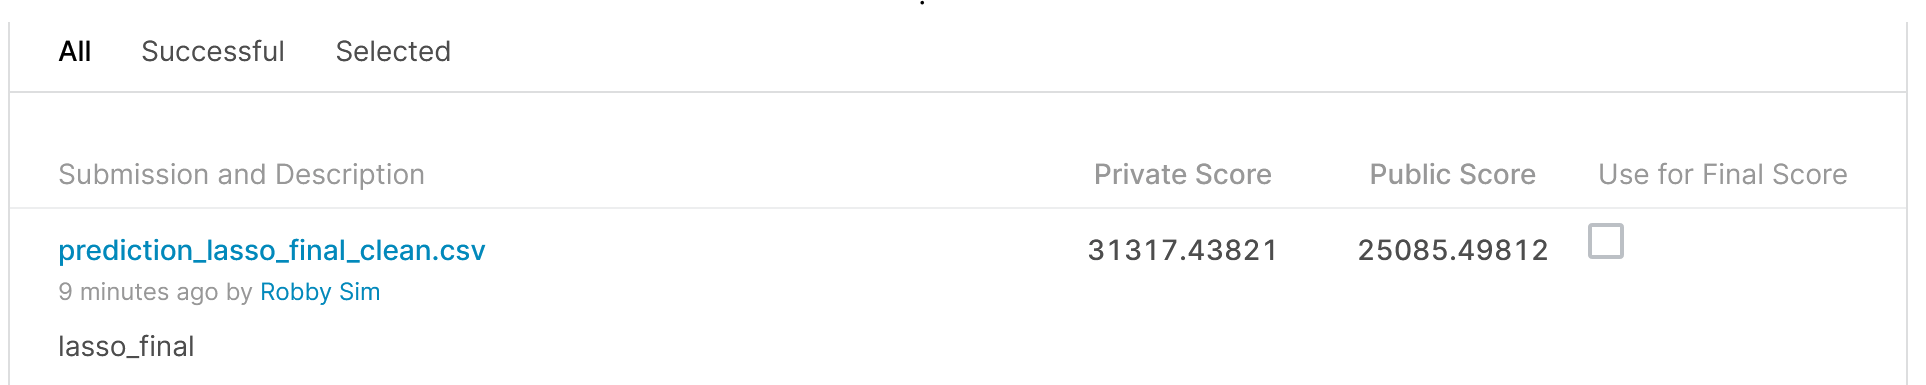

## Conclusion

In [263]:
len(ames.loc[ames['SalePrice'] >= np.log(300000)])

172

We believe our Lasso model is able to achieve high predictive powers below the 300,000 valuation, evidenced by how close the actual sale prices are to the prediction line. Also, we have avoided overfitting our model by not including many of the correlated features as well as polynomial and interactive terms that may make the model unwieldly and difficult to interpret. 

Any predictions that are above the 300,000 valuation mark should be treated with caution as our model tends to under-predict the actual values. However, it might not be a huge problem if we were to seek real estate investments, as we will then obtain a margin of safety from the supposedly true value of the house. Additionally, one important factor that our model's prediction power is decreased above this valuation range is due to the lower number of observations. From the charts above, we observed that the number of points above the 300,000 range became sparse, hence our model has less data to evaluate and generate predictions. In our entire training dataset, there were only 172 data points with Sale Prices above 300,000, translated to approximately 8% of the dataset. Conversely, we see that most of our observations are in the 100,000 - 200,000 range, and hence our model shows the greatest predictive powers in that range. 

To improve our model, an immediate and direct method would be to collect more data, especially in the 300,000 and above valuation range. This will allow our model to better learn and generate predictions. Additionally, this will also allow us to see if other features can be included that will further explain house prices for this price range.<br>

Overall, with the aid of our Lasso model, IREIF can target houses are that listed below our predicted price and subsequently generate good investment returns for the fund. 

## Addendum

In our reading of the original [research paper](http://jse.amstat.org/v19n3/decock.pdf) and [data documentation](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt) by the author, we notice a particular feature that was missing in the dataset provided in Kaggle, specifically:

Sale Condition (Nominal): Condition of sale

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
<br>
We believe removing this column impairs our model prediction as the condition of sale would provide information surrounding the circumstances of the sale price and whether it was a normal transaction or a distressed/fire sale. This will go a long way in helping our model identify the different types of sales and the distribution of sale prices to associate with it. <br>

Intuitively, as this feature is missing and not included, our model could only predict the sale price that is the average of all the sale conditions. Thus, our model does not distinguish between the sale condition which will probably lead to a higher predicted value for fire/distressed sales. 